# CRISP-DM on Swarm Behavior dataset

Este projeto tem o objetivo de desenvolver um modelo, que a partir de dados da classificação humana do comportamento de enxame, seja capaz de discernir se um conjunto de dados representando o movimento de boids está se movendo em bando ou não. A partir do dataset [Swarm Behavior](https://archive.ics.uci.edu/dataset/524/swarm+behaviour), que foi construído a partir de uma enquete online por UNSW, Australia, com 24017 instâncias e 2400 features, que a partir de vídeos, tinha o objetivo de classificar humanamente se um boid está em bando, alinhado ou agrupado.

In [ ]:
%pip install -U numpy==1.23.5
%pip install sklvq

  Using cached sklvq-0.1.2-py3-none-any.whl (71 kB)


In [ ]:
import os
import random
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

## Obtaining of the data

No dataset existem 200 boids, onde cada um deles possui 12 features (xN, yN, xVelN, yVelN, xAN, yAN, xSN, ySN, xCN, yCN, nACN, nSN), totalizando 2400 colunas, mas que, devido a natureza dos dados, ao analisar x1 por exemplo, não podemos ignorar as demais colunas xN, sendo então justificável a nossa escolha inicial de olharmos para estas N features como sendo correlacionadas, pelo menos para esta etapa inicial da análise de preparação dos dados.

In [ ]:
import pandas as pd

data = pd.read_csv("./Flocking.csv")
data = data.rename(columns={ "Class ": "flocking" })
data.head()

## Data Cleaning

Em busca de observar os tipos de dados, foi utilizado o método `info()` no DataFrame de dados, é observado que existem 3 tipos de dados `float64(1999), int64(401), object(1)`, sendo que não deveria haver nenhum tipo `object`.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24014 entries, 0 to 24013
Columns: 169 entries, xVel2 to flocking
dtypes: float64(89), int64(80)
memory usage: 31.0 MB


Isso foi causado por um valor incompleto (não numérico). Para resolver, foi removido as últimas duas instâncias, de forma a remover a instância com x1 incompleto que tem a classe 1 e a penúltima instância que tinha classe 0, para equilibrar a quantidade de classes (1 e 0), ficando 12007 instâncias para cada classe.

In [ ]:
# replace field that's entirely space (or empty) with NaN
data = data.replace(r'^\s*$', np.nan, regex=True)
data.isna().sum().sum()

1

<Axes: >

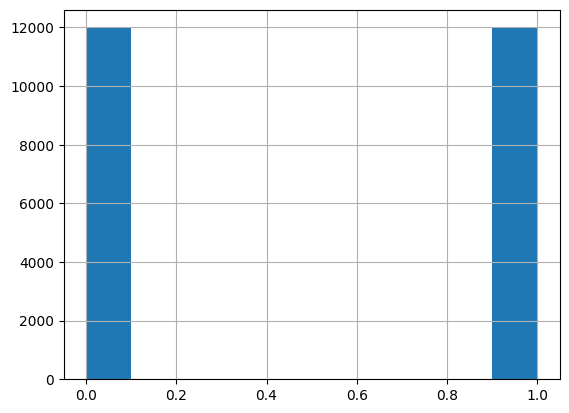

In [ ]:
# Convert x1 to int and fill the NA values
# treated_x1_column = data["x1"][~data["x1"].isna()].astype(data["y1"].dtype)
# data["x1"] = data["x1"].fillna(treated_x1_column.mean())

data = data[:-2] # Remove the last instance because x1 is " "
data["x1"] = data["x1"].astype(data["y1"].dtype)
data["flocking"].hist()

In [ ]:
print("Exists some null value: ", data.isnull().sum().any())
print("Exists some duplicated value: ", len(data[data.duplicated()]) > 0)

Exists some null value:  False
Exists some duplicated value:  False


## Exploratory data analysis

Uma vez que as informações de cada boid está disposto nas features, então para analisar cada uma das features foi agregado em um novo DataFrame no qual, por exemplo, a coluna “x” é a concatenação de x1…x200, e assim por diante.

In [ ]:
columns = [x[:-1] for x in data.columns[:12]]
aggr_data = pd.DataFrame(columns=columns)

for x in columns:
    aggr_data[x] = np.concatenate(tuple(data[x + str(y)] for y in range(1, 201)))

print(f"Transforming from {data.shape} to {aggr_data.shape}")
aggr_data.describe()

Transforming from (24014, 2401) to (4802800, 12)


,x,y,xVel,yVel,xA,yA,xS,yS,xC,yC,nAC,nS
count,4.802800e+06,4.802800e+06,4.802800e+06,4.802800e+06,4.802800e+06,4.802800e+06,4.802800e+06,4.802800e+06,4.802800e+06,4.802800e+06,4.802800e+06,4.802800e+06
mean,-5.594115e+01,-6.445431e+00,-1.408985e+00,2.200717e-01,-1.152558e-01,1.250735e-01,1.248792e+01,2.013798e+01,-5.200663e-02,8.654368e-02,2.368505e+01,1.789131e+00
std,7.995799e+02,5.614884e+02,5.936235e+00,7.692123e+00,3.860693e-01,5.823652e-01,6.007751e+03,7.691213e+03,5.523312e-01,6.138777e-01,3.138277e+01,6.433274e+00
min,-1.418250e+03,-1.018920e+03,-1.995000e+01,-1.999000e+01,-1.070000e+00,-1.120000e+00,-1.037197e+06,-1.048459e+06,-2.680000e+00,-2.680000e+00,0.000000e+00,0.000000e+00
25%,-7.383300e+02,-4.802300e+02,-6.000000e+00,-5.780000e+00,-1.700000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-4.000000e-02,0.000000e+00,2.000000e+00,0.000000e+00
50%,-1.067900e+02,-2.977000e+01,-1.130000e+00,-2.500000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,0.000000e+00
75%,6.177800e+02,4.635600e+02,2.030000e+00,7.480000e+00,0.000000e+00,6.600000e-01,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-02,3.500000e+01,1.000000e+00
max,1.417680e+03,1.018160e+03,1.983000e+01,1.978000e+01,1.100000e+00,1.100000e+00,3.692911e+06,4.191195e+06,2.680000e+00,2.680000e+00,1.710000e+02,1.080000e+02


### Distribution analysis

Esta célula exibe a distribuição de valores e suas contagens de cada uma das features agregadas (x, y...). Como as features variam em escalas diferentes, então será necessário realizar uma normalização ou padronização dos dados para se analisar gráficos de violino e correlação.

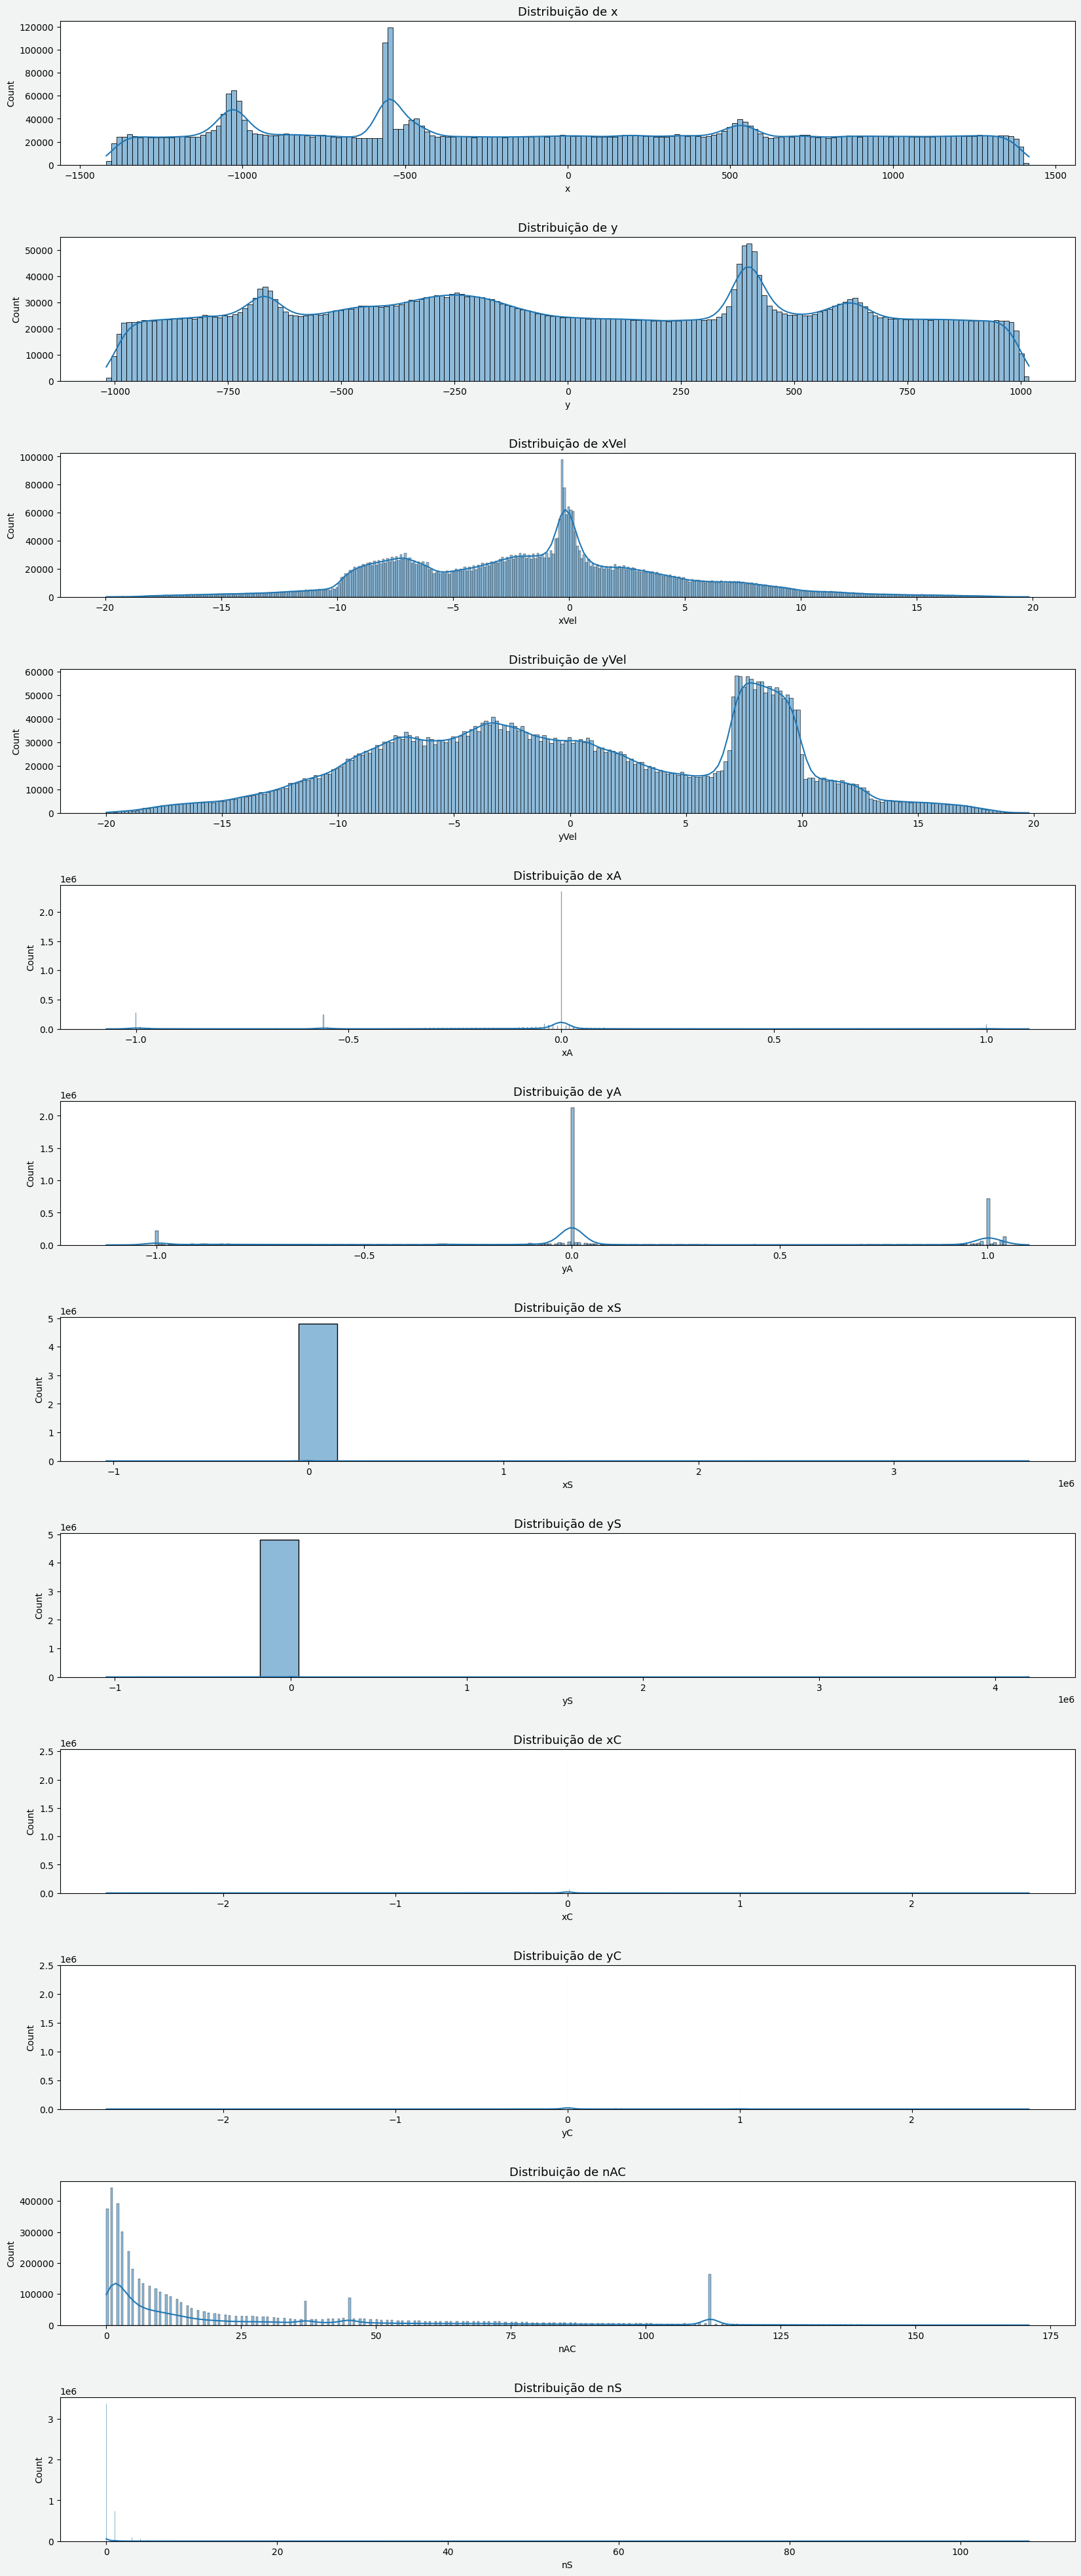

In [ ]:
fig, ax = plt.subplots(figsize=(20,50), facecolor='#F2F4F4')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
count=1

for x in columns:
    plt.subplot(len(columns), 1, count)
    h = sns.histplot(x=x, kde=True, data=aggr_data)
    h.set_title('Distribuição de ' + x, fontsize=13)
    count+=1

### Most Frequently analysis

Esta célula mostra os valores mais frequentes de cada uma das features agregadas e a quantidade de ocorrências de cada uma.

In [ ]:
# The most frequently values
for x in columns:
    counts = aggr_data[x].value_counts()
    biggest = counts.index.to_list()[0]
    value = counts[biggest]
    print(f"{x}:\tBiggest: {biggest} ({value}x)")

x:	Biggest: -545.66 (214x)
y:	Biggest: 393.77 (71x)
xVel:	Biggest: 0.02 (12333x)
yVel:	Biggest: 7.17 (3925x)
xA:	Biggest: 0.0 (2344821x)
yA:	Biggest: 0.0 (2124348x)
xS:	Biggest: 0.0 (3769915x)
yS:	Biggest: 0.0 (3769425x)
xC:	Biggest: 0.0 (2420329x)
yC:	Biggest: 0.0 (2387008x)
nAC:	Biggest: 1 (442504x)
nS:	Biggest: 0 (3366152x)


### Box-plot analysis

Esta célula mostra a análise de variação e outliers de cada uma das features agregadas, é perceptível que metade das features possuem muitos outliers: xVel (vetor x de velocidade), xA (vetor x de alinhamento), xC (vetor x de coesão), yC (vetor y de coesão), nAC (número de boids no ráio de Alinhamento/Coesão) e nS (número de boids no raio de separação).

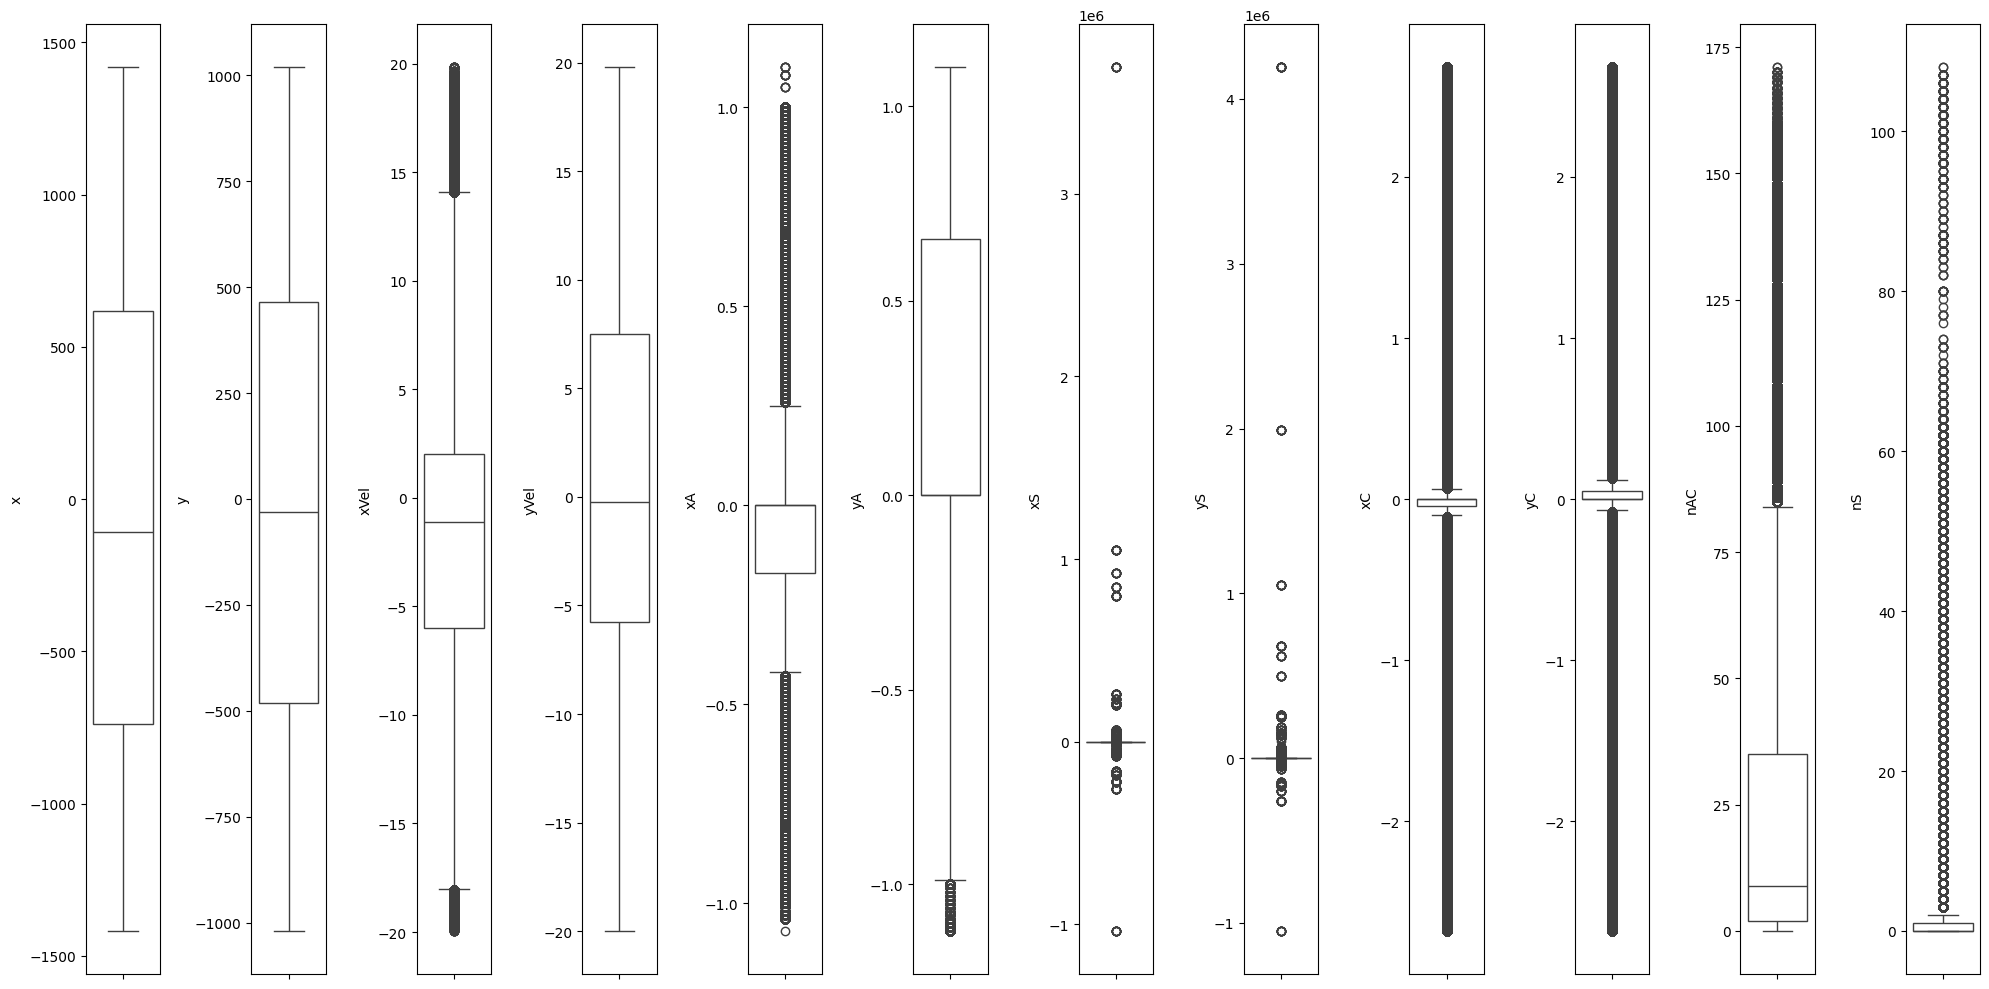

In [ ]:
def numeric_eda(df, hue=None):
    columns = df.select_dtypes(include=np.number).columns
    figure = plt.figure(figsize=(20, 10))
    figure.add_subplot(1, len(columns), 1)
    for index, col in enumerate(columns):
        if index > 0:
            figure.add_subplot(1, len(columns), index + 1)
        sns.boxplot(y=col, data=df, boxprops={'facecolor': 'None'})
    figure.tight_layout()

numeric_eda(aggr_data)

## Data preparation

Para realizar uma normalização ou padronização dos dados é necessário avaliamos a distribuição original dos dados para verificar se nossos dados seguem uma distribuição gaussiana. Através de estatística descritiva, podemos observar que a média e o desvio padrão dos dados não possuem proximidade, o que serve de constatação que o conjunto de dados não se ajusta adequadamente a uma curva gaussiana, assim, os dados serão normalizados.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scale_norm = MinMaxScaler()
normalised_aggr = scale_norm.fit_transform(aggr_data)

In [ ]:
y = pd.DataFrame(np.tile(data['flocking'].values, 200), columns=["flocking"])
x_df = pd.DataFrame(data=normalised_aggr, columns=columns)

### Violin graph

O gráfico de violino é semelhante ao boxplot, no qual mostra a distribuição dos dados após agrupar por uma ou mais features, porém mostrando uma representação da densidade dos dados. No nosso caso, estamos plotando o gráfico de forma vertical e dividindo a distribuição dos dados por classe. Dessa forma, se o gráfico apresentar apenas uma linha horizontal, significa que os dados são todos constantes, já se apresentar uma linha vertical, significa que estão muito dispersos.

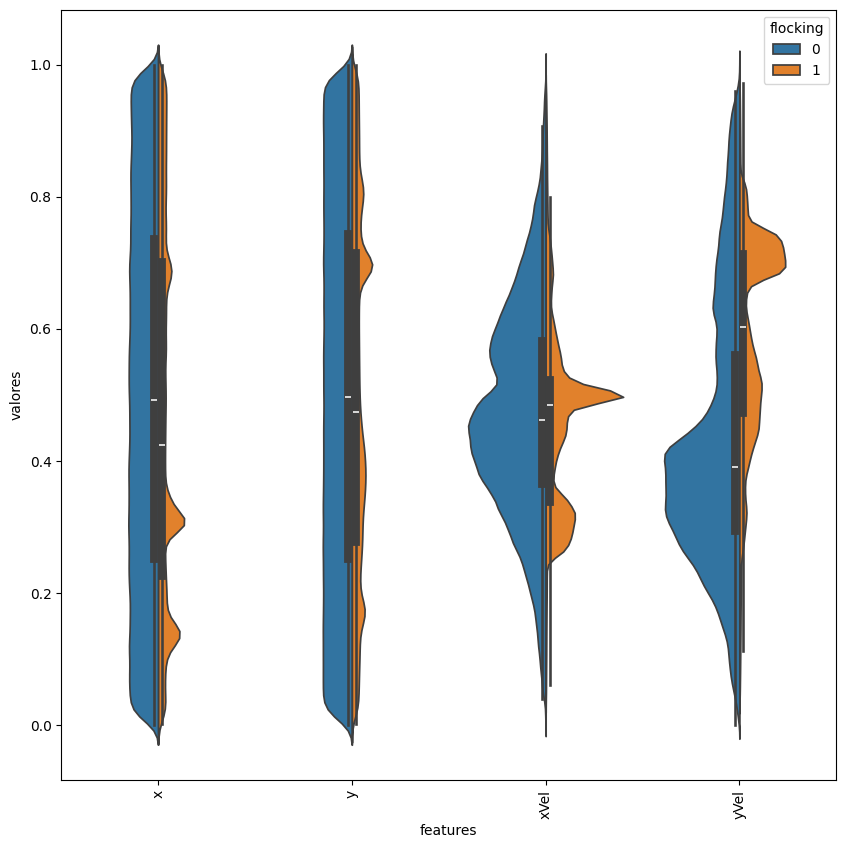

In [ ]:
import pandas, seaborn

def plot_violin_graph(x_values: pandas.DataFrame,
                      y_values: pandas.DataFrame,
                      y_name: str, x_name: str) -> None:
    data_plot = pandas.concat([y_values, x_values], axis=1)
    data_plot = pandas.melt(data_plot, id_vars=y_name, var_name=x_name,
                            value_name="valores")

    plt.figure(figsize=(10,10))

    seaborn.violinplot(x=x_name, y="valores", hue=y_name,
                       data=data_plot, split=True)

    plt.xticks(rotation = 90)

plot_violin_graph(x_df.iloc[:,:4], y, "flocking", "features")

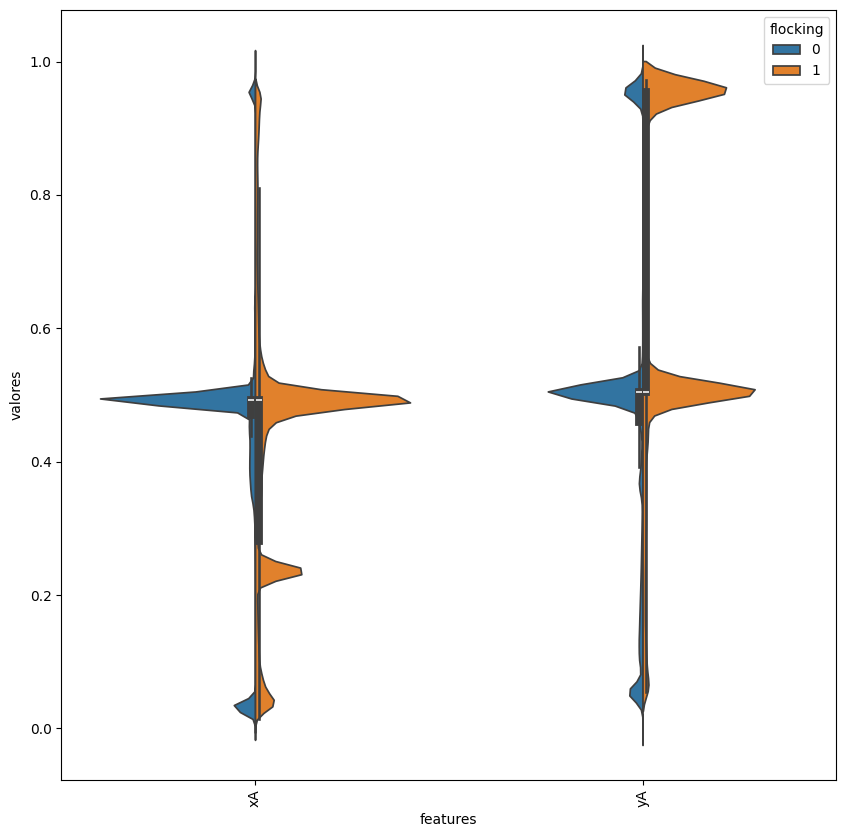

In [ ]:
plot_violin_graph(x_df.iloc[:,4:6], y, "flocking", "features")

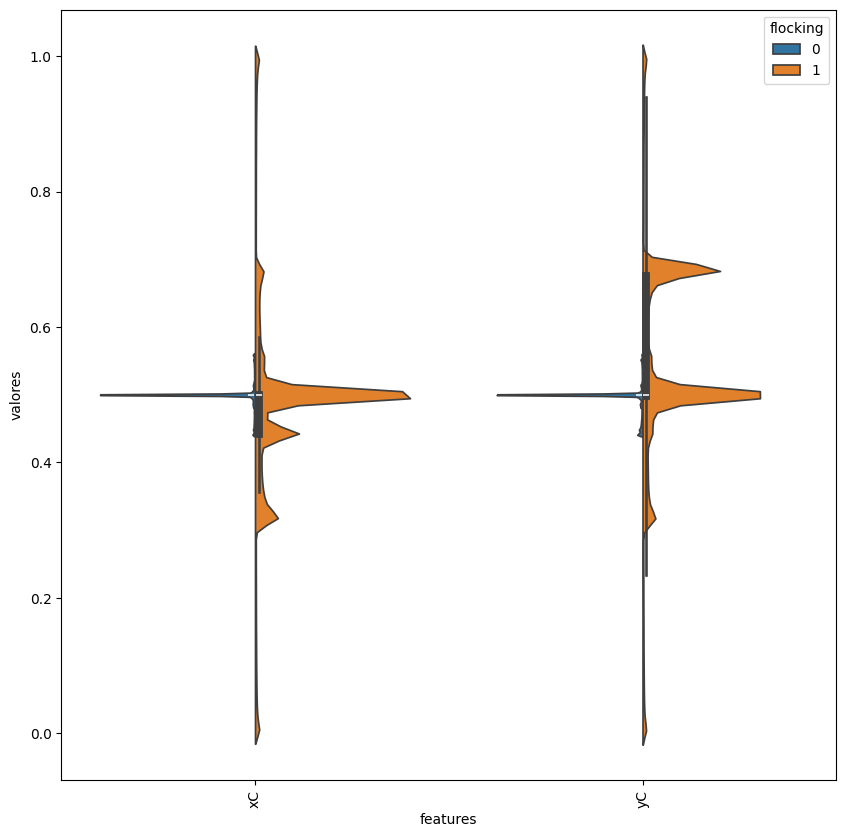

In [ ]:
plot_violin_graph(x_df.iloc[:,8:10], y, "flocking", "features")

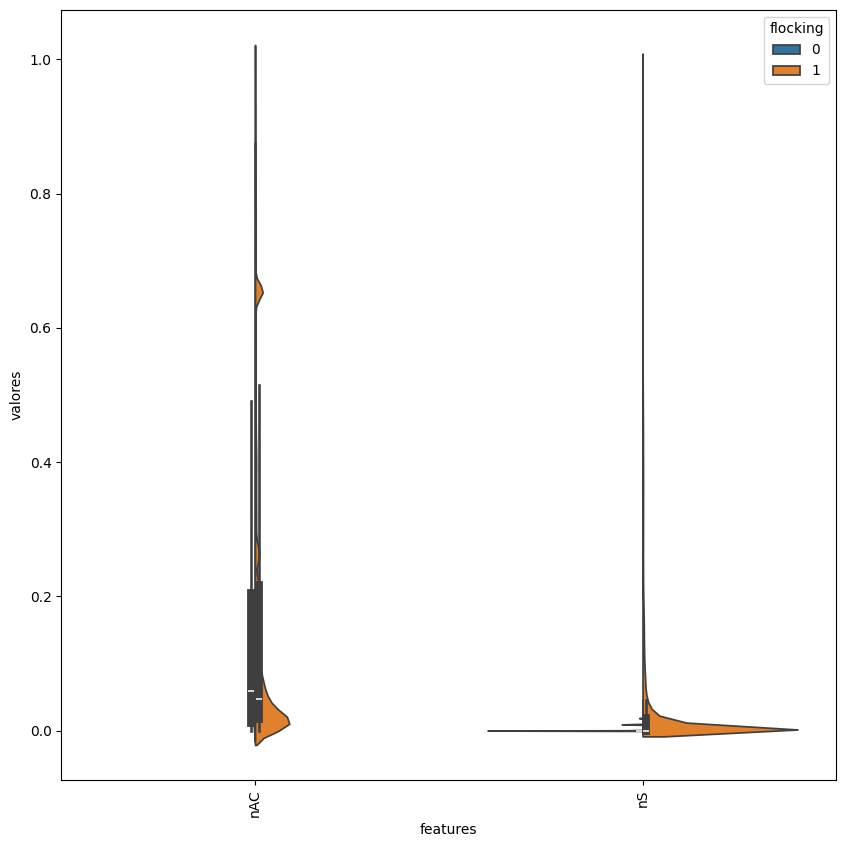

In [ ]:
plot_violin_graph(x_df.iloc[:,10:], y, "flocking", "features")

Analisando o gráfico de violino da feature xS e yS em relação às demais features, percebemos que apesar dessas features possuírem o maior desvio padrão e maior range de dados, de acordo com a análise exploratória, ainda assim, a sua distribuição é agrupada demais em um determinado ponto, corroborando com o gráfico boxplot da etapa anterior.

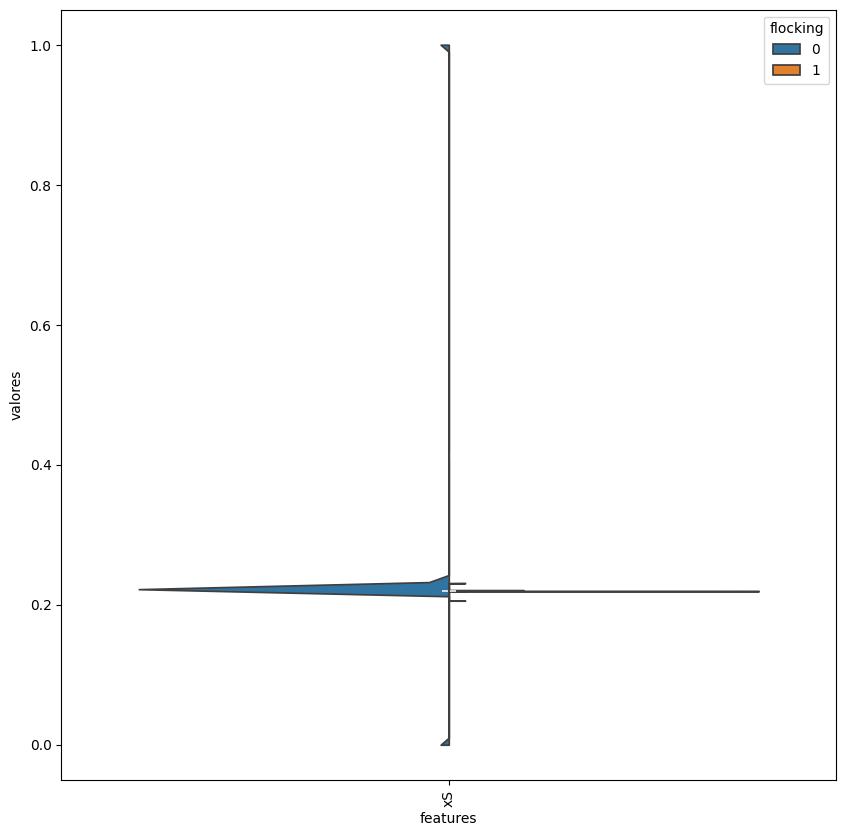

In [ ]:
plot_violin_graph(x_df.iloc[:,6:7], y, "flocking", "features")

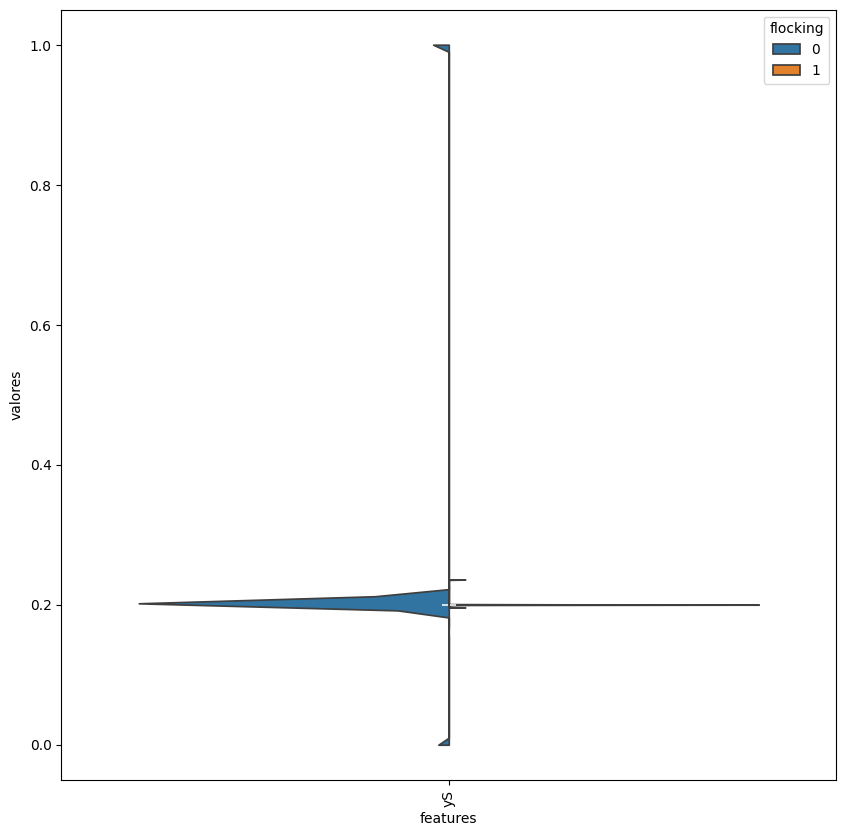

In [ ]:
plot_violin_graph(x_df.iloc[:,7:8], y, "flocking", "features")

### Confusion matrix

A análise de correlação das features, com um limiar de corte de 90%, não mostrou nenhuma feature muito correlacionada.

<Axes: >

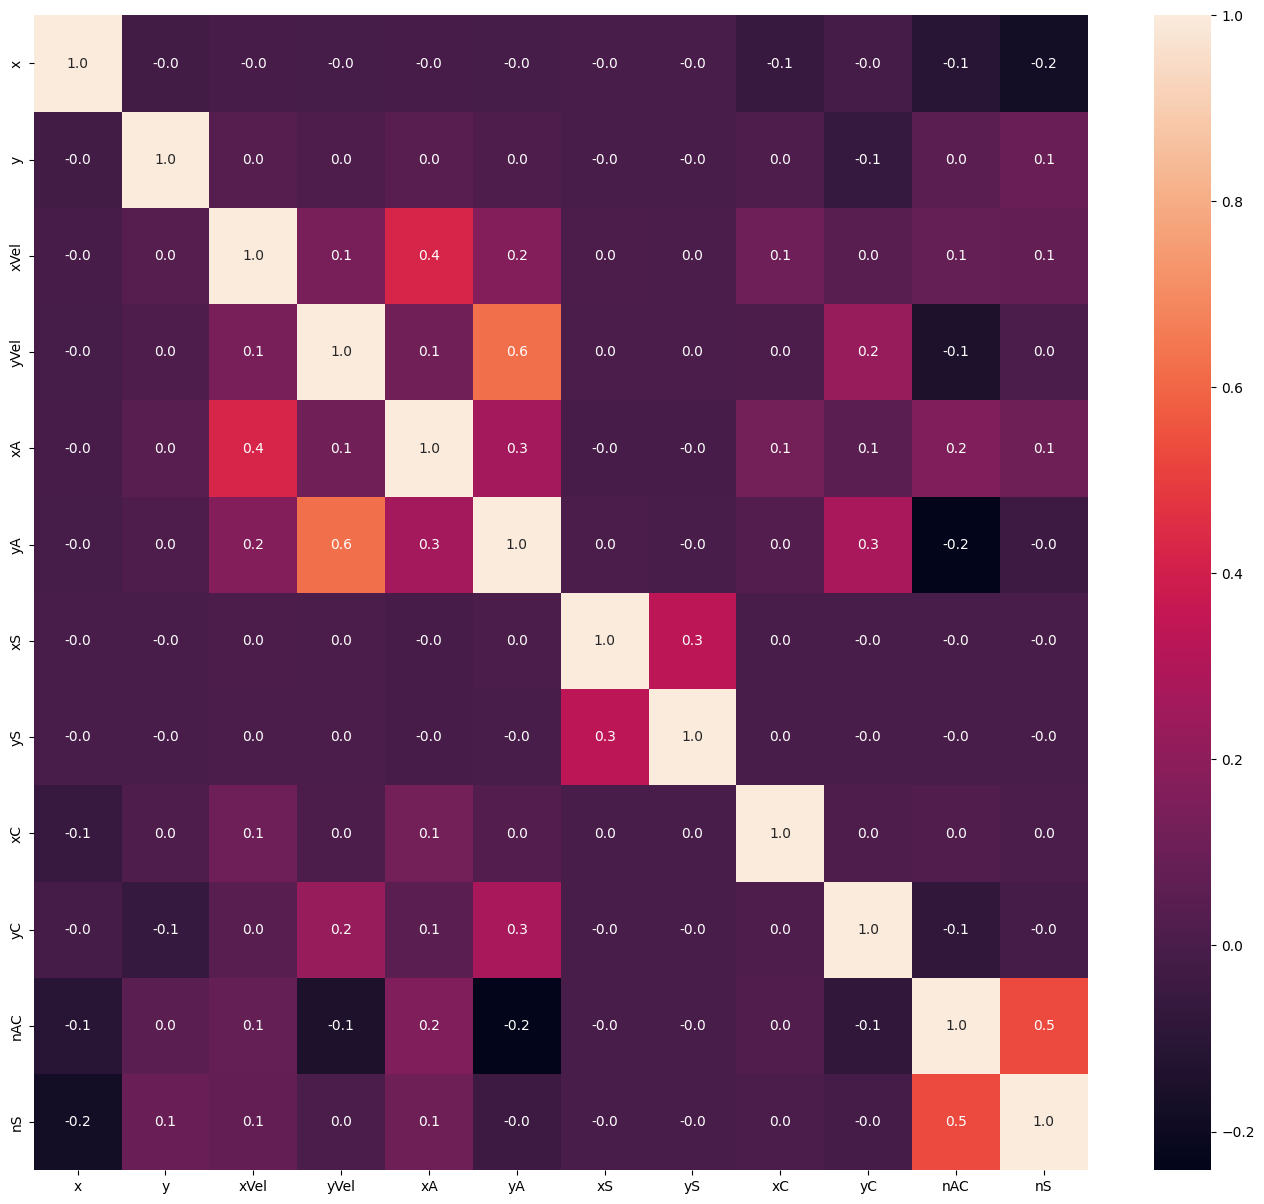

In [ ]:
corr_matrix = x_df.corr()
plt.figure(figsize=(17, 15))
seaborn.heatmap(corr_matrix, annot = True, fmt = ".1f")

In [ ]:
corr_matrix[corr_matrix[corr_matrix>0.99].sum() > 1]

,x,y,xVel,yVel,xA,yA,xS,yS,xC,yC,nAC,nS


### Feature selection

A seleção de features por teste univariado aplica testes estatísticos para encontrar relações entre a variável de saída e cada variável de entrada isoladamente, no qual cada teste é realizados uma variável de entrada por vez. Foi utilizado uma tarefa de classificação utilizando a pontuação f-classif e um p-value para cada variável.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

feature_selector = SelectKBest(f_classif, k = "all")
fit = feature_selector.fit(x_df, y)

scores = pd.DataFrame(fit.scores_)
p_values = pd.DataFrame(fit.pvalues_)
input_variable_names = pd.DataFrame(x_df.columns)
summary_stats = pd.concat([input_variable_names, p_values, scores], axis = 1)
summary_stats.columns = ["input_variable", "p_value", "f_score"]
summary_stats.sort_values(by = "p_value", inplace = True)

p_value_threshold = 0.05
score_threshold = 5

selected_variables = summary_stats.loc[(summary_stats["f_score"] >= score_threshold) &
                                       (summary_stats["p_value"] <= p_value_threshold)]
selected_variables = selected_variables["input_variable"].tolist()
selected_variables

['x', 'xVel', 'yVel', 'xA', 'yA', 'xC', 'yC', 'nAC', 'nS', 'yS', 'xS']

### Removing features by Variance

Uma vez que o gráfico de violino e a distribuição dos dados das features xS e yS, são de pouca variação, então escolhemos remove-las. Da mesma forma, a seleção por teste univariado removeu a feature y, apontando que até mesmo a feature x pode ser removido uma vez que possuímos a feature nS e nAC para determinar a quantidade de boids ao redor, logo, a posição dos boids não deve afetar tanto. Dessa forma, foram removidos as features x, y, xS e yS do dataset, reduzindo 800 features do dataset.

In [ ]:
features_to_remove = ["y", "xS", "yS"]
columns_to_remove = [f"{x}{i}" for x in features_to_remove for i in range(1, 201)]
data = data.drop(columns=columns_to_remove)
data.shape

(24014, 1801)

In [ ]:
X = data.drop(["flocking"], axis = 1)
y = data["flocking"]

In [ ]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=0.15)
new_x = sel.fit_transform(X)
variance_features = X.columns[sel.get_support(indices=True)]
print(variance_features)

Index(['x1', 'xVel1', 'yVel1', 'yA1', 'xC1', 'yC1', 'nAC1', 'nS1', 'x2',
       'xVel2',
       ...
       'nAC199', 'nS199', 'x200', 'xVel200', 'yVel200', 'yA200', 'xC200',
       'yC200', 'nAC200', 'nS200'],
      dtype='object', length=1689)


## Removing features by RFECV

Tendo em vista que o nosso dataset possui muitas features correlacionadas (xN, yN e demais features) optamos por implementar o método Recursive Feature Elimination with Cross-Validation (RFECV). A escolha se fundamenta na eficácia comprovada do RFECV em selecionar características relevantes de maneira sistemática. Ao iniciar com todas as variáveis e, de forma recursiva e validação cruzada, seleciona as features a partir da sua importância, dada pela acurácia no estimador escolhido (SVC linear).

In [ ]:
# from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.svm import LinearSVC

classifier = LinearSVC(random_state=SEED)
features_count = 12 - len(features_to_remove)
rfecv = RFECV(classifier, step=features_count, verbose=True, n_jobs=-1)

fit = rfecv.fit(new_x, y)

optimal_feature_count = rfecv.n_features_
print(f"Optimal number of features: {optimal_feature_count}")

new_x = new_x[:, rfecv.get_support()]
variance_features[rfecv.get_support(indices=True)]

Fitting estimator with 1689 features.
Fitting estimator with 1680 features.
Fitting estimator with 1671 features.
Fitting estimator with 1662 features.
Fitting estimator with 1653 features.
Fitting estimator with 1644 features.
Fitting estimator with 1635 features.
Fitting estimator with 1626 features.
Fitting estimator with 1617 features.
Fitting estimator with 1608 features.
Fitting estimator with 1599 features.
Fitting estimator with 1590 features.
Fitting estimator with 1581 features.
Fitting estimator with 1572 features.
Fitting estimator with 1563 features.
Fitting estimator with 1554 features.
Fitting estimator with 1545 features.
Fitting estimator with 1536 features.
Fitting estimator with 1527 features.
Fitting estimator with 1518 features.
Fitting estimator with 1509 features.
Fitting estimator with 1500 features.
Fitting estimator with 1491 features.
Fitting estimator with 1482 features.
Fitting estimator with 1473 features.
Fitting estimator with 1464 features.
Fitting esti

Index(['xVel2', 'nS2', 'xVel3', 'yVel3', 'yVel4', 'nS4', 'nS5', 'yVel6',
       'xVel7', 'nS9',
       ...
       'nS186', 'nS188', 'xVel190', 'nS191', 'nS192', 'xVel193', 'yVel193',
       'nS193', 'yVel195', 'yVel196'],
      dtype='object', length=168)

Text(0.5, 1.0, 'Recursive Feature Elimination \nwith correlated features')

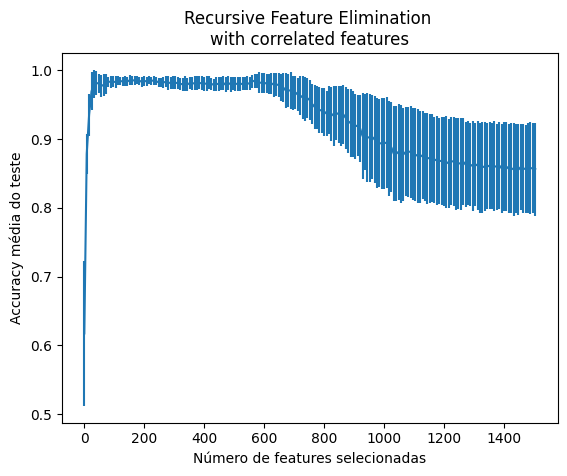

In [ ]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Número de features selecionadas")
plt.ylabel("Accuracy média do teste")
plt.errorbar(
    range(1, n_scores * 8, 8),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")

## Modeling

A partir do dataset simplificado, com as features importantes, será dividido em treino e teste, e realizado o treinamento de cada um dos seguintes modelos:


In [ ]:
from sklearn.model_selection import train_test_split

treino_x, teste_x, treino_y, teste_y = train_test_split(
    new_x, y, random_state = SEED, test_size = 0.3)

In [ ]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(treino_x, treino_y)
dummy.score(teste_x, teste_y)

### Auxiliar functions

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats._distn_infrastructure import rv_discrete_frozen
from scipy.stats import randint
from functools import reduce
import re

PATH = "./hiperparametros"
SCORING = "accuracy"

def search_params(name: str, model, space: dict, space_len: int, cv: int=10):
    cross_validation = StratifiedKFold(n_splits=cv, random_state=SEED)
    n_iter = min(max(int(space_len / 10), 5), 25)
    print(f"Searching {n_iter}/{space_len} params of {name}")
    search = RandomizedSearchCV(model, space, n_iter=n_iter, random_state=SEED,
                                scoring=SCORING, n_jobs=-1, cv=cross_validation,
                                error_score='raise')
    result = search.fit(treino_x, treino_y)
    results_df = pd.DataFrame(result.cv_results_)

    print(f"Saving params results in {PATH}/{name}.csv")
    columns_to_keep = [x for x in results_df.columns
                       if "_score_time" not in x and "_fit_time" not in x and
                       not re.match(r"split\d+_test_score", x)]
    results_df = results_df.sort_values(by="rank_test_score", axis=0)
    results_df = results_df[columns_to_keep]
    results_df.to_csv(f"{PATH}/{name}.csv", index=False)

    return result, results_df

def get_space_len(prev, current):
    if isinstance(current, rv_discrete_frozen):
        current_len = current.b - current.a + 1
    else:
        current_len = len(current)
    return prev * current_len

def remove_params_from_df(results: pd.DataFrame, params_dist: dict):
    last_param_idx = list(results.columns).index("params")
    middle_idx = int(len(results) / 2)
    to_update_results = dict()

    for i in range(last_param_idx):
        column_name = results.columns[i]
        column = results[column_name].to_list()

        good_params = column[:middle_idx]
        bad_params = column[middle_idx:]
        params_to_remove = set(bad_params).difference(good_params)
        if len(params_to_remove) == 0: continue
        to_update_results[column_name] = params_to_remove

        column_name = column_name[6:]
        params = params_dist[column_name]
        if not isinstance(params, rv_discrete_frozen):
            print(f"Removing {params_to_remove} params from {column_name}")
            params_dist[column_name] = [x for x in params if x not in params_to_remove]

    for key, value in to_update_results.items():
        results = results[~results[key].isin(value)]

    return results, params_dist

def concatenate_results(results: pd.DataFrame, results_2: pd.DataFrame):
    results = np.concatenate((results, results_2))
    results = pd.DataFrame(results, columns=results_2.columns)
    return results.sort_values(by="mean_test_score",
                               axis=False, ascending=False)

In [ ]:
def get_agg_params_search(name: str):
    columns = ["attempt", "name", "rank_test_score", "mean_test_score"]

    # Get the params attempts from files
    params_list = []
    for i in range(1, 4):
        file_name = f"/{name}"
        if i > 1: name += f"_{i}"
        params = pd.read_csv(PATH + file_name + ".csv")
        params_list.append(params)

    # Set the groups and names
    for i, params in enumerate(params_list):
        params["attempt"] = f"n{i + 1}"
        attempt_list = (params.index + 1).astype(str)
        params["name"] = params["attempt"] + "-" + attempt_list
        params = params[columns].sort_values(by="rank_test_score",
                                             ascending=False)
        params_list[i] = params

    return pd.DataFrame(np.concatenate(params_list), columns=columns)

def show_params_search_graph(name: str, y_size: int=10):
    agg_params = get_agg_params_search(name)

    plt.figure(figsize=(30, y_size))
    plt.xticks(rotation=90)
    ax = sns.barplot(palette="pastel",
                    x=agg_params["name"],
                    hue=agg_params["attempt"],
                    y=agg_params['mean_test_score'])

    fmt_pct = lambda x: str(round(x * 100, 2)) + "%"
    for container in ax.containers:
        ax.bar_label(container, padding=10, rotation=90,
                    fmt=fmt_pct, label_type="center")

    plt.xlabel('Os N melhores de cada execução')
    plt.ylabel('Pontuação média')
    plt.title('Busca de Parâmetros')

    plt.figure(figsize=(20, int(y_size / 2)))
    plt.xticks(rotation=90)

    sorted_params = agg_params.sort_values(by="mean_test_score")
    sns.lineplot(palette="pastel", x=sorted_params["name"],
                y=sorted_params['mean_test_score'])

    plt.xlabel('Os N melhores de cada execução')
    plt.ylabel('Pontuação média')
    plt.title('Busca de Parâmetros')

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_leaf_nodes': [None, 10, 20, 30, 40],
    'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4],
    'class_weight': [None, 'balanced']
}

decisionTree = DecisionTreeClassifier()

In [ ]:
space_len = reduce(get_space_len, param_dist.values(), 1)

dt_search, dt_results = search_params("dtree", decisionTree,
                                      param_dist, space_len)

dt_score = dt_search.best_score_
dt_params = dt_search.best_params_

print(dt_score, dt_params)
dt_results.head()

Searching 25/128000 params of dtree
Saving params results in /content/drive/MyDrive/dtree.csv
0.9969064261635647 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 6, 'splitter': 'best'}


,param_class_weight,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,param_splitter,params,mean_test_score,std_test_score,rank_test_score
5,balanced,gini,10,None,30,0.0,3,6,best,"{'class_weight': 'balanced', 'criterion': 'gin...",0.996906,0.001403,1
12,balanced,gini,None,auto,40,0.0,1,8,best,"{'class_weight': 'balanced', 'criterion': 'gin...",0.989529,0.004556,2
10,balanced,entropy,15,sqrt,30,0.0,2,9,best,"{'class_weight': 'balanced', 'criterion': 'ent...",0.983521,0.005275,3
22,None,entropy,5,log2,30,0.0,3,7,best,"{'class_weight': None, 'criterion': 'entropy',...",0.955917,0.017876,4
24,None,entropy,10,auto,40,0.0,3,3,random,"{'class_weight': None, 'criterion': 'entropy',...",0.954131,0.009670,5


In [ ]:
dt_results, param_dist = remove_params_from_df(dt_results, param_dist)

Removing {20} params from max_depth
Removing {None} params from max_leaf_nodes
Removing {0.3, 0.4} params from min_impurity_decrease


In [ ]:
space_len = reduce(get_space_len, param_dist.values(), 1)
decisionTree = DecisionTreeClassifier()

dt_search, dt_results_2 = search_params("dtree_2", decisionTree,
                                        param_dist, space_len)

dt_score = dt_search.best_score_
dt_params = dt_search.best_params_

dt_results = concatenate_results(dt_results, dt_results_2)
dt_results, param_dist = remove_params_from_df(dt_results, param_dist)

print(dt_score, dt_params)
dt_results_2.head()

Searching 25/49152 params of dtree_2
Saving params results in /content/drive/MyDrive/dtree_2.csv
0.9835207217925837 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': 40, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 6, 'splitter': 'best'}


,param_class_weight,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,param_splitter,params,mean_test_score,std_test_score,rank_test_score
5,balanced,gini,15,log2,40,0.0,3,6,best,"{'class_weight': 'balanced', 'criterion': 'gin...",0.983521,0.005638,1
13,None,entropy,15,None,10,0.0,1,8,best,"{'class_weight': None, 'criterion': 'entropy',...",0.968707,0.004563,2
21,None,entropy,10,auto,40,0.0,4,5,random,"{'class_weight': None, 'criterion': 'entropy',...",0.954669,0.016233,3
14,None,gini,10,auto,40,0.0,4,9,random,"{'class_weight': None, 'criterion': 'gini', 'm...",0.949611,0.012584,4
18,balanced,entropy,5,log2,30,0.0,3,6,best,"{'class_weight': 'balanced', 'criterion': 'ent...",0.948123,0.016065,5


In [ ]:
decisionTree = DecisionTreeClassifier()
space_len = reduce(get_space_len, param_dist.values(), 1)

dt_search, dt_results_2 = search_params("dtree_3", decisionTree,
                                        param_dist, space_len)

dt_score = dt_search.best_score_
dt_params = dt_search.best_params_

print(dt_score, dt_params)
dt_results_2.head()

Searching 25/49152 params of dtree_3
Saving params results in /content/drive/MyDrive/dtree_3.csv
0.985543646072349 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': 40, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 6, 'splitter': 'best'}


,param_class_weight,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,param_splitter,params,mean_test_score,std_test_score,rank_test_score
5,balanced,gini,15,log2,40,0.0,3,6,best,"{'class_weight': 'balanced', 'criterion': 'gin...",0.985544,0.006937,1
13,None,entropy,15,None,10,0.0,1,8,best,"{'class_weight': None, 'criterion': 'entropy',...",0.968707,0.004563,2
14,None,gini,10,auto,40,0.0,4,9,random,"{'class_weight': None, 'criterion': 'gini', 'm...",0.954310,0.015236,3
18,balanced,entropy,5,log2,30,0.0,3,6,best,"{'class_weight': 'balanced', 'criterion': 'ent...",0.948480,0.014140,4
21,None,entropy,10,auto,40,0.0,4,5,random,"{'class_weight': None, 'criterion': 'entropy',...",0.940031,0.013079,5


In [ ]:
dt_results = concatenate_results(dt_results, dt_results_2)

idx = dt_results[0:1]["mean_test_score"].index[0]
dt_score = dt_results[0:1]["mean_test_score"][idx]
dt_params = dt_results[0:1]["params"][idx]
print(dt_score, dt_params)

0.9969064261635647 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 6, 'splitter': 'best'}


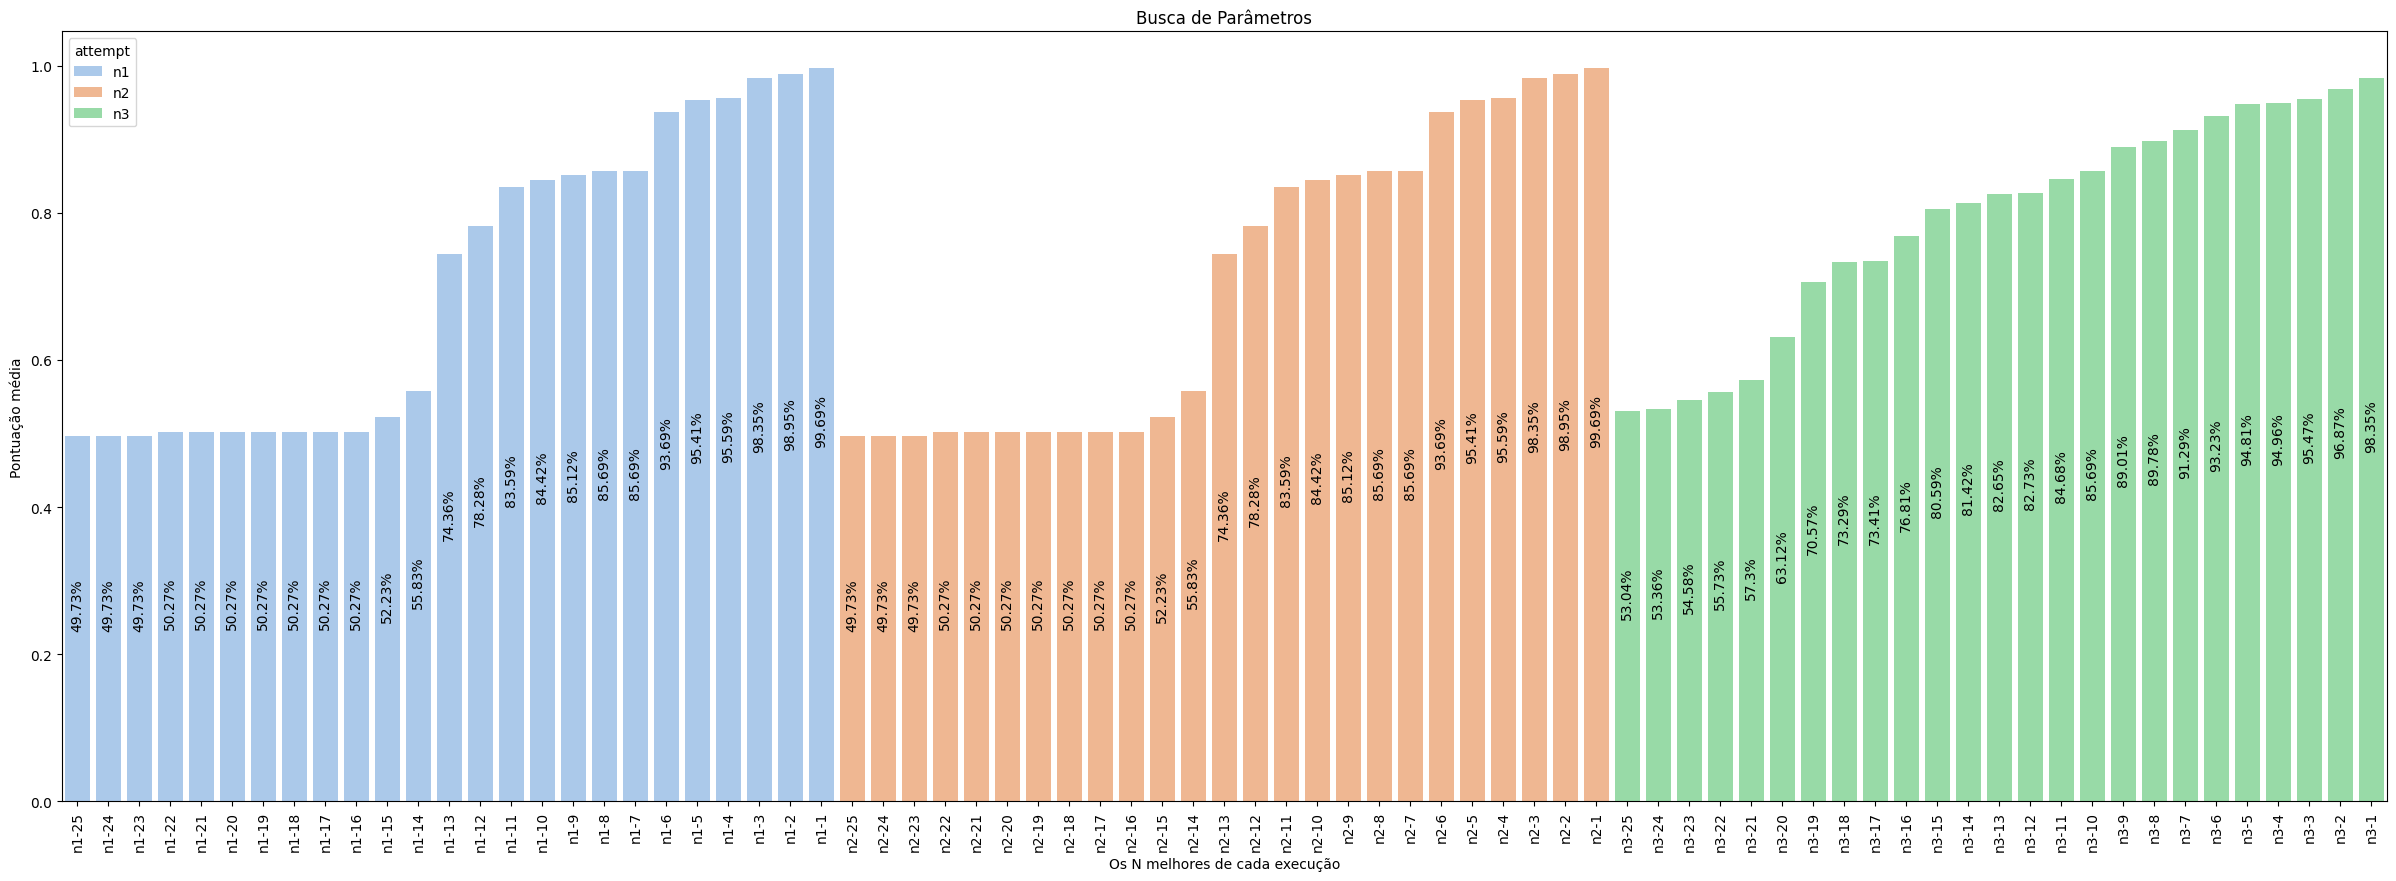

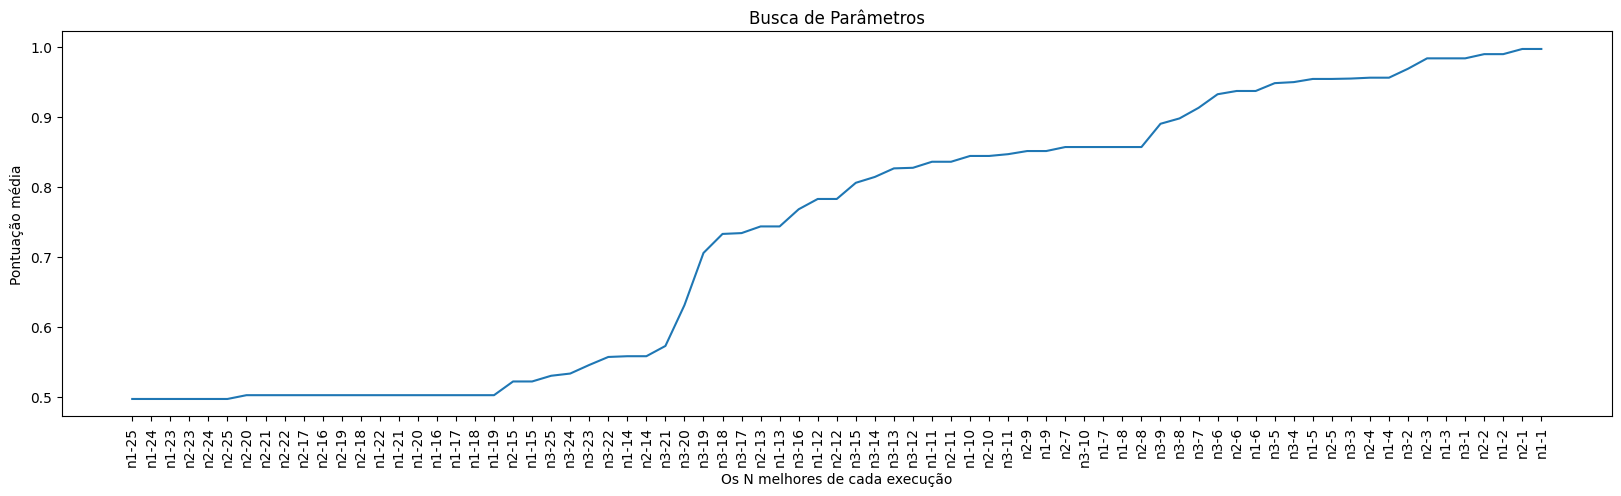

In [ ]:
show_params_search_graph("dtree")

### SVM

In [ ]:
from sklearn.svm import SVC

param_dist = {
    'C': [0.1, 1, 10, 100],
    'degree': [2, 3, 4, 5],
    'tol': [1e-3, 1e-4, 1e-5],
    'gamma': ['scale', 'auto'],
    'shrinking': [True, False],
    'probability': [True, False],
    'coef0': [0.0, 0.1, 0.2, 0.3, 0.4],
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'class_weight': [None, 'balanced'],
    'max_iter': [100, 250, 500, 750, 1000]
}

svc = SVC()

In [ ]:
space_len = reduce(get_space_len, param_dist.values(), 1)

svc_search, svc_results = search_params("svc", svc, param_dist, space_len)

svc_score = svc_search.best_score_
svc_params = svc_search.best_params_

print(svc_score, svc_params)
svc_results.head()

Searching 25/57600 params of svc
Saving params results in /content/drive/MyDrive/svc.csv
0.9999405116002379 {'tol': 1e-05, 'shrinking': True, 'probability': False, 'max_iter': 500, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'coef0': 0.1, 'class_weight': None, 'C': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


,param_tol,param_shrinking,param_probability,param_max_iter,param_kernel,param_gamma,param_degree,param_coef0,param_class_weight,param_C,params,mean_test_score,std_test_score,rank_test_score
24,0.0001,True,False,100,rbf,scale,3,0.2,balanced,100,"{'tol': 0.0001, 'shrinking': True, 'probabilit...",0.999941,0.000178,1
5,0.00001,True,False,500,rbf,scale,2,0.1,None,100,"{'tol': 1e-05, 'shrinking': True, 'probability...",0.999941,0.000178,1
12,0.0001,True,False,500,poly,scale,5,0.2,None,100,"{'tol': 0.0001, 'shrinking': True, 'probabilit...",0.999881,0.000238,3
13,0.0001,True,False,500,poly,auto,4,0.0,None,100,"{'tol': 0.0001, 'shrinking': True, 'probabilit...",0.999822,0.000273,4
15,0.00001,True,True,1000,poly,scale,4,0.3,balanced,10,"{'tol': 1e-05, 'shrinking': True, 'probability...",0.999762,0.000291,5


In [ ]:
svc_results, param_dist = remove_params_from_df(svc_results, param_dist)

Removing {750} params from max_iter
Removing {'sigmoid'} params from kernel
Removing {0.4} params from coef0


In [ ]:
space_len = reduce(get_space_len, param_dist.values(), 1)
svc = SVC()

svc_search, svc_results_2 = search_params("svc_2", svc, param_dist, space_len)

svc_score = svc_search.best_score_
svc_params = svc_search.best_params_

svc_results = concatenate_results(svc_results, svc_results_2)
svc_results, param_dist = remove_params_from_df(svc_results, param_dist)

print(svc_score, svc_params)
svc_results_2.head()

Searching 25/24576 params of svc_2
Saving params results in /content/drive/MyDrive/svc_2.csv
0.9999405116002379 {'tol': 1e-05, 'shrinking': False, 'probability': False, 'max_iter': 250, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'coef0': 0.0, 'class_weight': 'balanced', 'C': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


,param_tol,param_shrinking,param_probability,param_max_iter,param_kernel,param_gamma,param_degree,param_coef0,param_class_weight,param_C,params,mean_test_score,std_test_score,rank_test_score
19,0.001,False,False,500,poly,auto,2,0.3,None,0.1,"{'tol': 0.001, 'shrinking': False, 'probabilit...",0.999941,0.000178,1
11,0.00001,True,True,500,rbf,scale,4,0.0,balanced,100,"{'tol': 1e-05, 'shrinking': True, 'probability...",0.999941,0.000178,1
4,0.00001,False,False,250,rbf,scale,2,0.0,balanced,100,"{'tol': 1e-05, 'shrinking': False, 'probabilit...",0.999941,0.000178,1
8,0.0001,True,True,500,poly,auto,2,0.0,None,1,"{'tol': 0.0001, 'shrinking': True, 'probabilit...",0.999881,0.000238,4
0,0.00001,True,True,1000,poly,scale,5,0.2,balanced,100,"{'tol': 1e-05, 'shrinking': True, 'probability...",0.999881,0.000238,5


In [ ]:
space_len = reduce(get_space_len, param_dist.values(), 1)
svc = SVC()

svc_search, svc_results_2 = search_params("svc_3", svc, param_dist, space_len)

svc_score = svc_search.best_score_
svc_params = svc_search.best_params_

print(svc_score, svc_params)
svc_results_2.head()

Searching 25/24576 params of svc_3
Saving params results in /content/drive/MyDrive/svc_3.csv
0.9999405116002379 {'tol': 1e-05, 'shrinking': False, 'probability': False, 'max_iter': 250, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 2, 'coef0': 0.0, 'class_weight': 'balanced', 'C': 100}


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


,param_tol,param_shrinking,param_probability,param_max_iter,param_kernel,param_gamma,param_degree,param_coef0,param_class_weight,param_C,params,mean_test_score,std_test_score,rank_test_score
19,0.001,False,False,500,poly,auto,2,0.3,None,0.1,"{'tol': 0.001, 'shrinking': False, 'probabilit...",0.999941,0.000178,1
11,0.00001,True,True,500,rbf,scale,4,0.0,balanced,100,"{'tol': 1e-05, 'shrinking': True, 'probability...",0.999941,0.000178,1
4,0.00001,False,False,250,rbf,scale,2,0.0,balanced,100,"{'tol': 1e-05, 'shrinking': False, 'probabilit...",0.999941,0.000178,1
8,0.0001,True,True,500,poly,auto,2,0.0,None,1,"{'tol': 0.0001, 'shrinking': True, 'probabilit...",0.999881,0.000238,4
0,0.00001,True,True,1000,poly,scale,5,0.2,balanced,100,"{'tol': 1e-05, 'shrinking': True, 'probability...",0.999881,0.000238,5


In [ ]:
svc_results = concatenate_results(svc_results, svc_results_2)

idx = svc_results[0:1]["mean_test_score"].index[0]
svc_score = svc_results[0:1]["mean_test_score"][idx]
svc_params = svc_results[0:1]["params"][idx]
print(svc_score, svc_params)

0.9999405116002379 {'tol': 0.0001, 'shrinking': True, 'probability': False, 'max_iter': 100, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'coef0': 0.2, 'class_weight': 'balanced', 'C': 100}


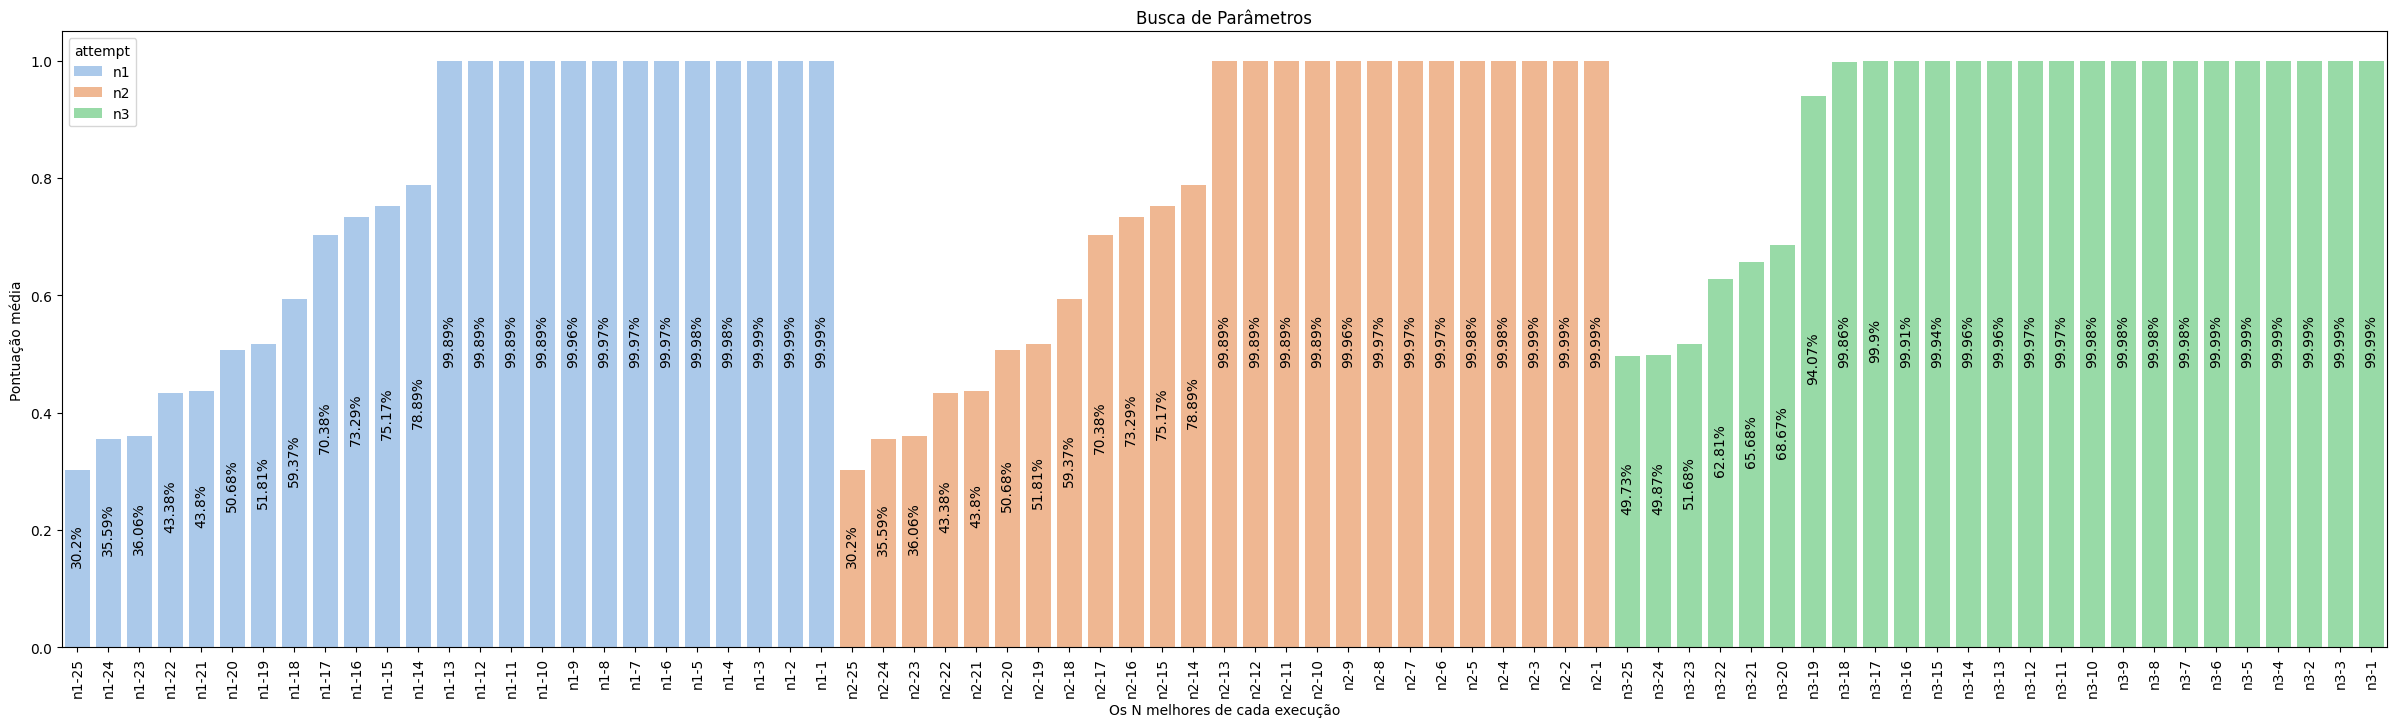

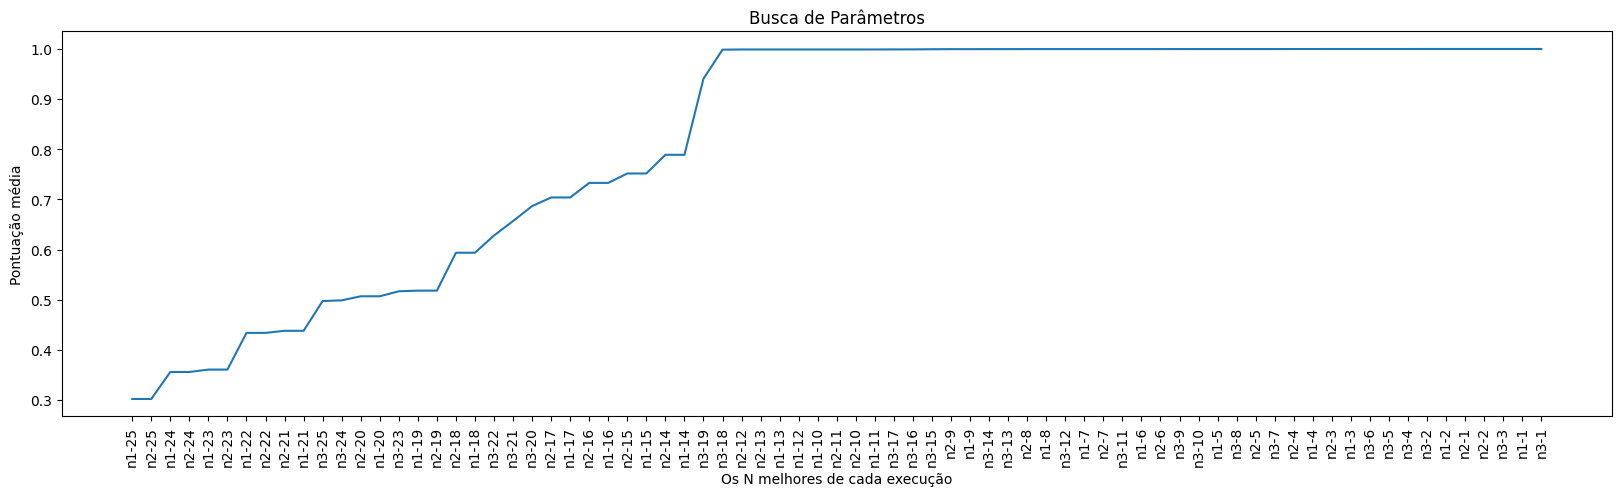

In [ ]:
show_params_search_graph("svc", 8)

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

param_dist = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 20, 30, 40],
    'p': [1, 2, 3, 4],
    'metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev'],
}

knn = KNeighborsClassifier(n_jobs=-1)

In [ ]:
space_len = reduce(get_space_len, param_dist.values(), 1)

knn_search, knn_results = search_params("knn", knn, param_dist, space_len)

knn_score = knn_search.best_score_
knn_params = knn_search.best_params_

print(knn_score, knn_params)
knn_results.head()

Searching 25/2560 params of knn
Saving params results in /content/drive/MyDrive/knn.csv
0.9999405116002379 {'weights': 'uniform', 'p': 2, 'n_neighbors': 3, 'metric': 'euclidean', 'leaf_size': 20, 'algorithm': 'kd_tree'}


,param_weights,param_p,param_n_neighbors,param_metric,param_leaf_size,param_algorithm,params,mean_test_score,std_test_score,rank_test_score
19,uniform,3,3,manhattan,30,brute,"{'weights': 'uniform', 'p': 3, 'n_neighbors': ...",0.999941,0.000178,1
9,uniform,2,3,euclidean,20,kd_tree,"{'weights': 'uniform', 'p': 2, 'n_neighbors': ...",0.999941,0.000178,1
12,distance,3,3,manhattan,30,kd_tree,"{'weights': 'distance', 'p': 3, 'n_neighbors':...",0.999881,0.000238,3
17,distance,4,5,manhattan,40,ball_tree,"{'weights': 'distance', 'p': 4, 'n_neighbors':...",0.999881,0.000238,3
16,distance,1,11,minkowski,40,brute,"{'weights': 'distance', 'p': 1, 'n_neighbors':...",0.999881,0.000238,3


In [ ]:
knn_results, param_dist = remove_params_from_df(knn_results, param_dist)

Removing {'chebyshev'} params from metric


In [ ]:
space_len = reduce(get_space_len, param_dist.values(), 1)
knn = KNeighborsClassifier(n_jobs=-1)

knn_search, knn_results_2 = search_params("knn_2", knn, param_dist, space_len)

knn_score = knn_search.best_score_
knn_params = knn_search.best_params_

print(knn_score, knn_params)
knn_results_2.head()

Searching 25/1920 params of knn_2
Saving params results in /content/drive/MyDrive/knn_2.csv
0.9999405116002379 {'weights': 'uniform', 'p': 2, 'n_neighbors': 3, 'metric': 'minkowski', 'leaf_size': 10, 'algorithm': 'ball_tree'}


,param_weights,param_p,param_n_neighbors,param_metric,param_leaf_size,param_algorithm,params,mean_test_score,std_test_score,rank_test_score
12,uniform,1,3,euclidean,40,kd_tree,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.999941,0.000178,1
21,uniform,1,3,manhattan,10,kd_tree,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.999941,0.000178,1
18,uniform,1,3,minkowski,20,auto,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.999941,0.000178,1
7,uniform,2,3,minkowski,10,ball_tree,"{'weights': 'uniform', 'p': 2, 'n_neighbors': ...",0.999941,0.000178,1
24,uniform,4,7,manhattan,30,auto,"{'weights': 'uniform', 'p': 4, 'n_neighbors': ...",0.999941,0.000178,1


In [ ]:
knn_results = concatenate_results(knn_results, knn_results_2)
knn_results, param_dist = remove_params_from_df(knn_results, param_dist)

In [ ]:
space_len = reduce(get_space_len, param_dist.values(), 1)
knn = KNeighborsClassifier(n_jobs=-1)

knn_search, knn_results_2 = search_params("knn_3", knn, param_dist, space_len)

knn_score = knn_search.best_score_
knn_params = knn_search.best_params_

print(knn_score, knn_params)
knn_results_2.head()

Searching 25/1920 params of knn_3
Saving params results in /content/drive/MyDrive/knn_3.csv
0.9999405116002379 {'weights': 'uniform', 'p': 2, 'n_neighbors': 3, 'metric': 'minkowski', 'leaf_size': 10, 'algorithm': 'ball_tree'}


,param_weights,param_p,param_n_neighbors,param_metric,param_leaf_size,param_algorithm,params,mean_test_score,std_test_score,rank_test_score
12,uniform,1,3,euclidean,40,kd_tree,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.999941,0.000178,1
21,uniform,1,3,manhattan,10,kd_tree,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.999941,0.000178,1
18,uniform,1,3,minkowski,20,auto,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.999941,0.000178,1
7,uniform,2,3,minkowski,10,ball_tree,"{'weights': 'uniform', 'p': 2, 'n_neighbors': ...",0.999941,0.000178,1
24,uniform,4,7,manhattan,30,auto,"{'weights': 'uniform', 'p': 4, 'n_neighbors': ...",0.999941,0.000178,1


In [ ]:
knn_results = concatenate_results(knn_results, knn_results_2)

idx = knn_results[0:1]["mean_test_score"].index[0]
knn_score = knn_results[0:1]["mean_test_score"][idx]
knn_params = knn_results[0:1]["params"][idx]
print(knn_score, knn_params)

0.9999405116002379 {'weights': 'uniform', 'p': 3, 'n_neighbors': 3, 'metric': 'manhattan', 'leaf_size': 30, 'algorithm': 'brute'}


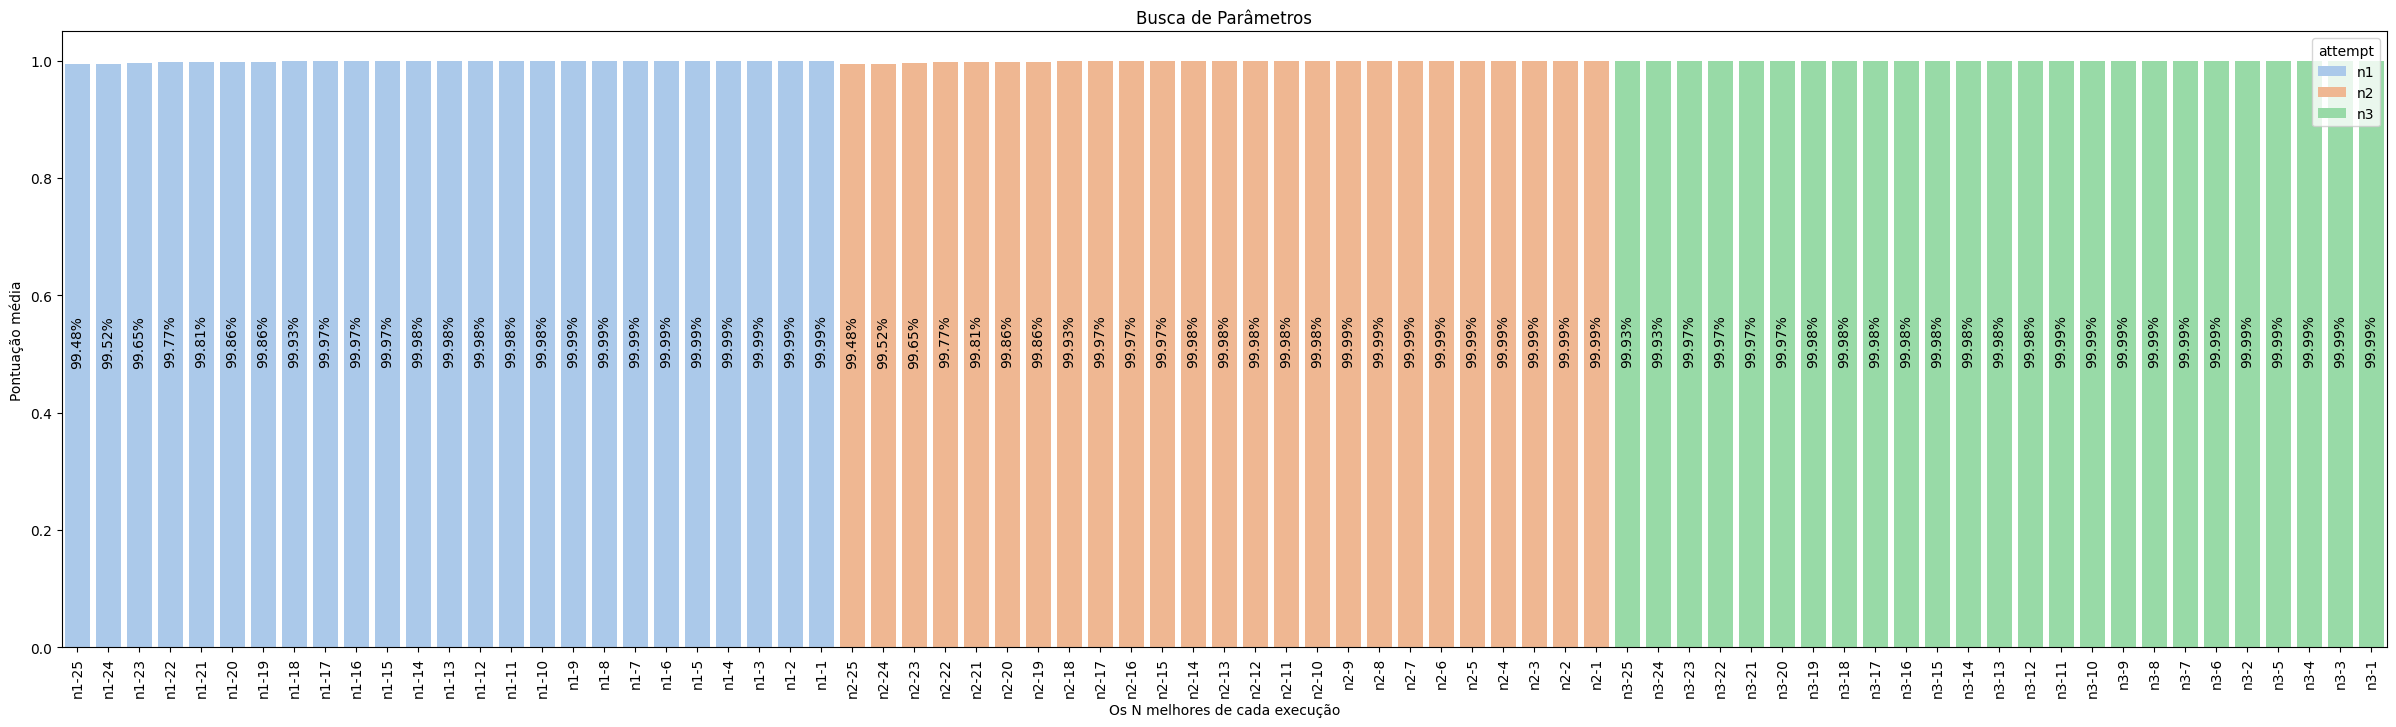

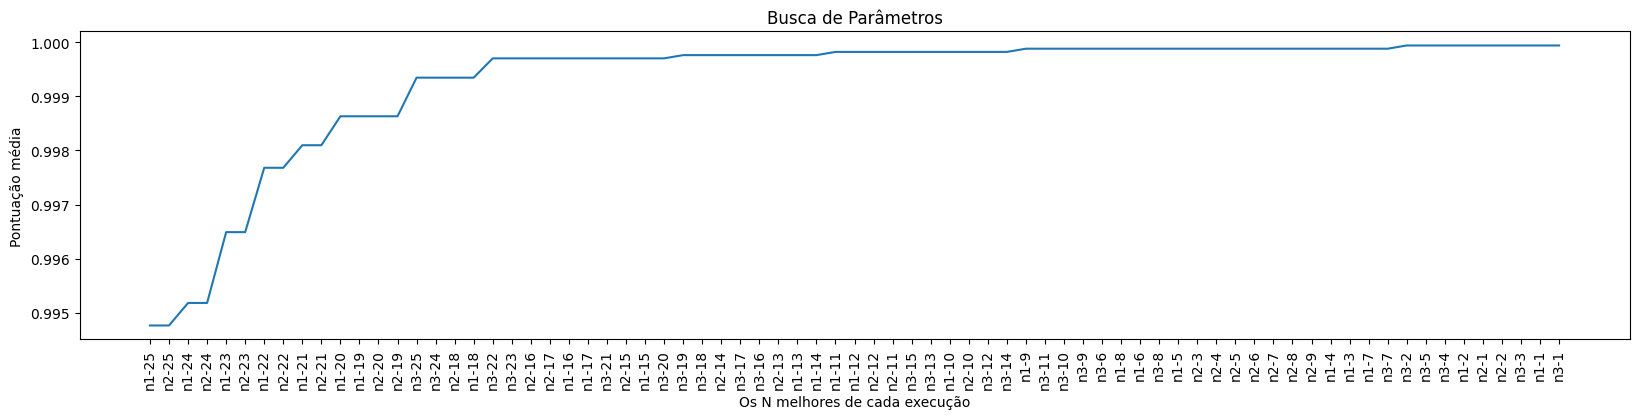

In [ ]:
show_params_search_graph("knn", 8)

### MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (200,), (50, 50), (100, 100), (150, 150), (200, 200)],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'validation_fraction': [0.1, 0.15, 0.2],
    'batch_size': ['auto', 100, 200, 500],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'nesterovs_momentum': [True, False],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'max_iter': [200, 400, 600, 800],
    'early_stopping': [True, False],
    'momentum': [0.9, 0.95, 0.99],
    'epsilon': [1e-8, 1e-7, 1e-6],
    'warm_start': [False, True],
    'tol': [1e-4, 1e-3, 1e-2],
    'shuffle': [True, False],
    'beta_1': [0.9, 0.99],
    'beta_2': [0.999, 0.9999],
}

mlp = MLPClassifier()

In [ ]:
space_len = reduce(get_space_len, param_dist.values(), 1)

mlp_search, mlp_results = search_params("mlp", mlp, param_dist, space_len)

mlp_score = mlp_search.best_score_
mlp_params = mlp_search.best_params_

mlp_results, param_dist = remove_params_from_df(mlp_results, param_dist)

print(mlp_score, mlp_params)
mlp_results.head()

Searching 25/95551488 params of mlp
Saving params results in /content/drive/MyDrive/mlp.csv
Removing {(100,), (50, 50)} params from hidden_layer_sizes
0.9999405116002379 {'warm_start': False, 'validation_fraction': 0.2, 'tol': 0.001, 'solver': 'lbfgs', 'shuffle': False, 'nesterovs_momentum': False, 'momentum': 0.99, 'max_iter': 200, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (150,), 'epsilon': 1e-08, 'early_stopping': True, 'beta_2': 0.999, 'beta_1': 0.9, 'batch_size': 200, 'alpha': 0.001, 'activation': 'tanh'}


,param_warm_start,param_validation_fraction,param_tol,param_solver,param_shuffle,param_nesterovs_momentum,param_momentum,param_max_iter,param_learning_rate,param_hidden_layer_sizes,...,param_early_stopping,param_beta_2,param_beta_1,param_batch_size,param_alpha,param_activation,params,mean_test_score,std_test_score,rank_test_score
1,False,0.2,0.001,lbfgs,False,False,0.99,200,adaptive,"(150,)",...,True,0.999,0.9,200,0.001,tanh,"{'warm_start': False, 'validation_fraction': 0...",0.999941,0.000178,1
5,True,0.1,0.001,adam,False,True,0.99,400,invscaling,"(150,)",...,False,0.9999,0.99,500,0.001,logistic,"{'warm_start': True, 'validation_fraction': 0....",0.999941,0.000178,1
11,True,0.1,0.001,sgd,False,True,0.99,800,adaptive,"(150,)",...,False,0.999,0.9,500,0.01,relu,"{'warm_start': True, 'validation_fraction': 0....",0.999941,0.000178,1
17,True,0.15,0.001,lbfgs,True,True,0.99,400,constant,"(150, 150)",...,False,0.999,0.9,200,0.0001,identity,"{'warm_start': True, 'validation_fraction': 0....",0.999941,0.000178,1
22,True,0.2,0.0001,lbfgs,True,False,0.99,400,invscaling,"(100, 100)",...,False,0.999,0.99,100,0.01,tanh,"{'warm_start': True, 'validation_fraction': 0....",0.999941,0.000178,1


In [ ]:
mlp = MLPClassifier()
space_len = reduce(get_space_len, param_dist.values(), 1)

mlp_search, mlp_results_2 = search_params("mlp_2", mlp, param_dist, space_len)

mlp_score = mlp_search.best_score_
mlp_params = mlp_search.best_params_

mlp_results = concatenate_results(mlp_results, mlp_results_2)
mlp_results, param_dist = remove_params_from_df(mlp_results, param_dist)

print(mlp_score, mlp_params)
mlp_results.head()

Searching 25/95551488 params of mlp_2
Saving params results in /content/drive/MyDrive/mlp_2.csv
Removing {'(50, 50)', '(100,)', (100,)} params from hidden_layer_sizes
0.9999405116002379 {'warm_start': True, 'validation_fraction': 0.15, 'tol': 0.0001, 'solver': 'sgd', 'shuffle': False, 'nesterovs_momentum': True, 'momentum': 0.95, 'max_iter': 600, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (150, 150), 'epsilon': 1e-06, 'early_stopping': False, 'beta_2': 0.9999, 'beta_1': 0.99, 'batch_size': 500, 'alpha': 0.01, 'activation': 'tanh'}


,param_warm_start,param_validation_fraction,param_tol,param_solver,param_shuffle,param_nesterovs_momentum,param_momentum,param_max_iter,param_learning_rate,param_hidden_layer_sizes,...,param_early_stopping,param_beta_2,param_beta_1,param_batch_size,param_alpha,param_activation,params,mean_test_score,std_test_score,rank_test_score
0,False,0.2,0.001,lbfgs,False,False,0.99,200,adaptive,"(150,)",...,True,0.999,0.9,200,0.001,tanh,"{'warm_start': False, 'validation_fraction': 0...",0.999941,0.000178,1
1,True,0.1,0.001,adam,False,True,0.99,400,invscaling,"(150,)",...,False,0.9999,0.99,500,0.001,logistic,"{'warm_start': True, 'validation_fraction': 0....",0.999941,0.000178,1
2,True,0.1,0.001,sgd,False,True,0.99,800,adaptive,"(150,)",...,False,0.999,0.9,500,0.01,relu,"{'warm_start': True, 'validation_fraction': 0....",0.999941,0.000178,1
3,True,0.15,0.001,lbfgs,True,True,0.99,400,constant,"(150, 150)",...,False,0.999,0.9,200,0.0001,identity,"{'warm_start': True, 'validation_fraction': 0....",0.999941,0.000178,1
4,True,0.2,0.0001,lbfgs,True,False,0.99,400,invscaling,"(100, 100)",...,False,0.999,0.99,100,0.01,tanh,"{'warm_start': True, 'validation_fraction': 0....",0.999941,0.000178,1


In [ ]:
mlp = MLPClassifier()
space_len = reduce(get_space_len, param_dist.values(), 1)

mlp_search, mlp_results_2 = search_params("mlp_3", mlp, param_dist, space_len)

mlp_score = mlp_search.best_score_
mlp_params = mlp_search.best_params_

mlp_results = concatenate_results(mlp_results, mlp_results_2)
mlp_results, param_dist = remove_params_from_df(mlp_results, param_dist)

print(mlp_score, mlp_params)
mlp_results.head()

Searching 25/83607552 params of mlp_3
Saving params results in /content/drive/MyDrive/mlp_3.csv
0.9999405116002379 {'warm_start': True, 'validation_fraction': 0.1, 'tol': 0.001, 'solver': 'adam', 'shuffle': False, 'nesterovs_momentum': True, 'momentum': 0.99, 'max_iter': 400, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (50, 50), 'epsilon': 1e-08, 'early_stopping': False, 'beta_2': 0.9999, 'beta_1': 0.9, 'batch_size': 500, 'alpha': 0.01, 'activation': 'logistic'}


,param_warm_start,param_validation_fraction,param_tol,param_solver,param_shuffle,param_nesterovs_momentum,param_momentum,param_max_iter,param_learning_rate,param_hidden_layer_sizes,...,param_early_stopping,param_beta_2,param_beta_1,param_batch_size,param_alpha,param_activation,params,mean_test_score,std_test_score,rank_test_score
0,False,0.2,0.001,lbfgs,False,False,0.99,200,adaptive,"(150,)",...,True,0.999,0.9,200,0.001,tanh,"{'warm_start': False, 'validation_fraction': 0...",0.999941,0.000178,1
1,True,0.1,0.001,adam,False,True,0.99,400,invscaling,"(150,)",...,False,0.9999,0.99,500,0.001,logistic,"{'warm_start': True, 'validation_fraction': 0....",0.999941,0.000178,1
2,True,0.1,0.001,sgd,False,True,0.99,800,adaptive,"(150,)",...,False,0.999,0.9,500,0.01,relu,"{'warm_start': True, 'validation_fraction': 0....",0.999941,0.000178,1
3,True,0.15,0.001,lbfgs,True,True,0.99,400,constant,"(150, 150)",...,False,0.999,0.9,200,0.0001,identity,"{'warm_start': True, 'validation_fraction': 0....",0.999941,0.000178,1
4,True,0.2,0.0001,lbfgs,True,False,0.99,400,invscaling,"(100, 100)",...,False,0.999,0.99,100,0.01,tanh,"{'warm_start': True, 'validation_fraction': 0....",0.999941,0.000178,1


In [ ]:
mlp_results = concatenate_results(mlp_results, mlp_results_2)

idx = mlp_results[0:1]["mean_test_score"].index[0]
mlp_score = mlp_results[0:1]["mean_test_score"][idx]
mlp_params = mlp_results[0:1]["params"][idx]
print(mlp_score, mlp_params)

0.999940511600238 {'warm_start': False, 'validation_fraction': 0.2, 'tol': 0.001, 'solver': 'lbfgs', 'shuffle': False, 'nesterovs_momentum': False, 'momentum': 0.99, 'max_iter': 200, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (150,), 'epsilon': 1e-08, 'early_stopping': True, 'beta_2': 0.999, 'beta_1': 0.9, 'batch_size': 200, 'alpha': 0.001, 'activation': 'tanh'}


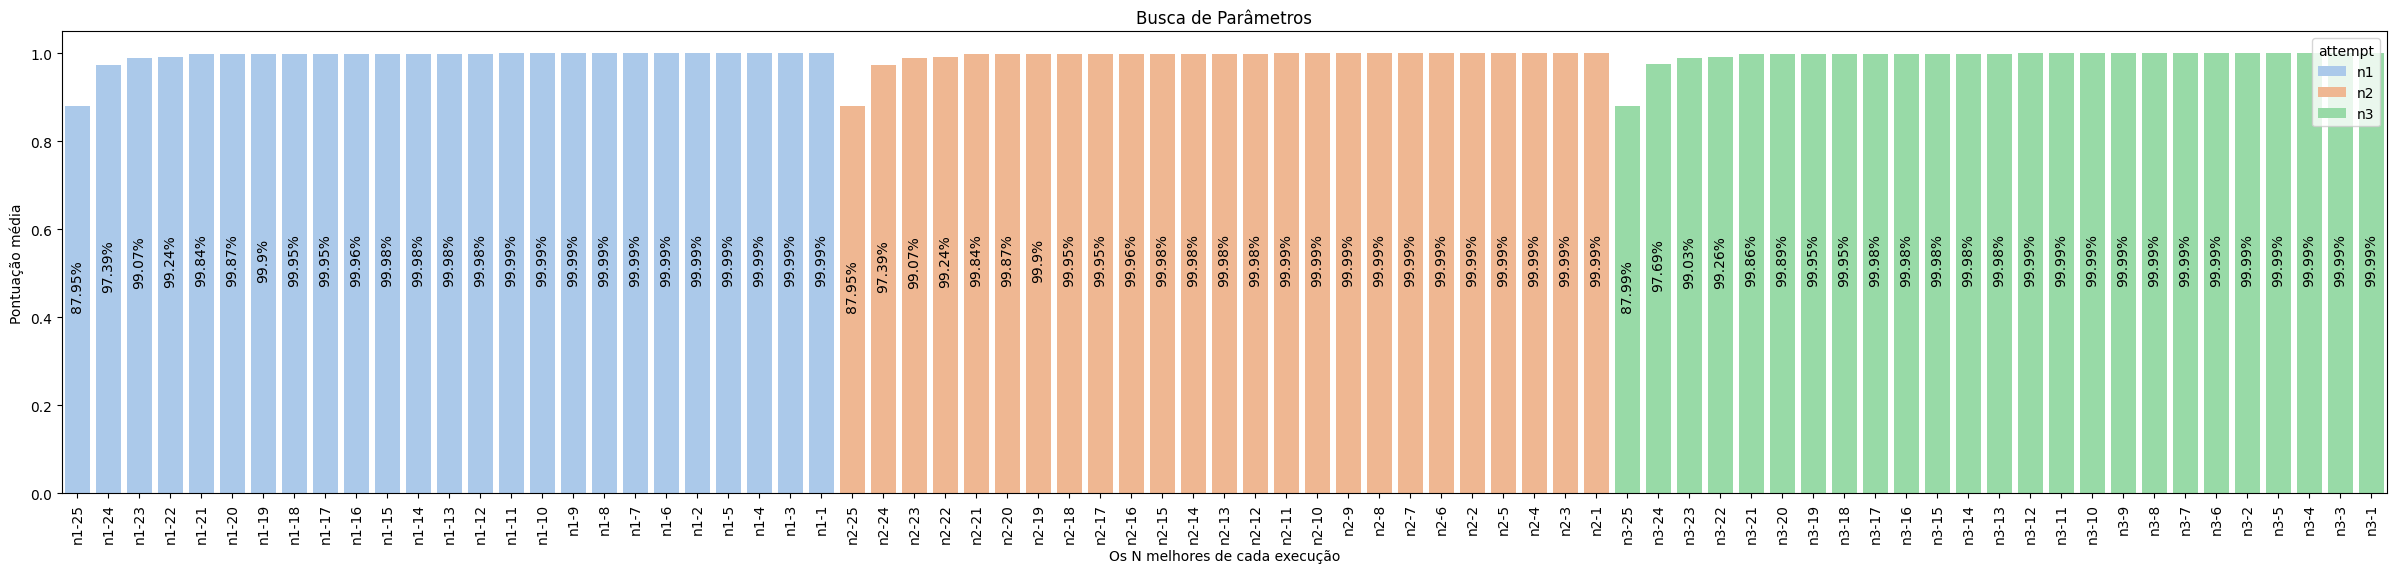

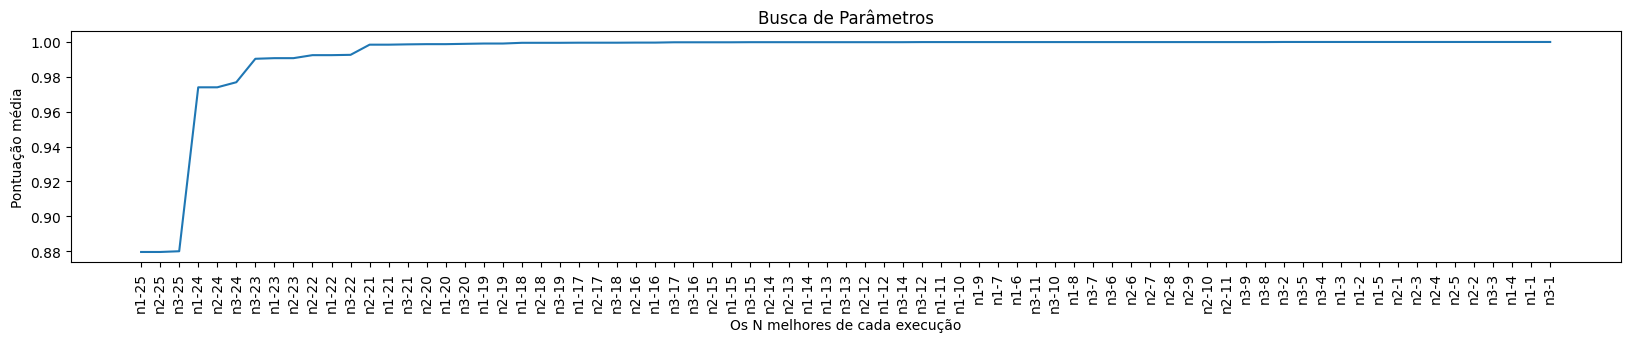

In [ ]:
show_params_search_graph("mlp", 6)

### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None],
    'max_leaf_nodes': [None, 10, 20, 30, 40],
    'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4],
    'oob_score': [True, False],
    'warm_start': [False, True],
}

rfc = RandomForestClassifier(n_jobs=-1)

In [ ]:
space_len = reduce(get_space_len, param_dist.values(), 1)

rfc_search, rfc_results = search_params("rfc", rfc, param_dist, space_len)

rfc_score = rfc_search.best_score_
rfc_params = rfc_search.best_params_

rfc_results, param_dist = remove_params_from_df(rfc_results, param_dist)

print(rfc_score, rfc_params)
rfc_results.head()

Searching 25/82080000 params of rfc
Saving params results in /content/drive/MyDrive/rfc.csv
Removing {0.4, 0.3} params from min_impurity_decrease
0.999702522591428 {'max_depth': 15, 'max_features': 'log2', 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 262, 'oob_score': False, 'warm_start': False}


,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_oob_score,param_warm_start,params,mean_test_score,std_test_score,rank_test_score
12,9,sqrt,40,0.0,1,8,58,False,False,"{'max_depth': 9, 'max_features': 'sqrt', 'max_...",0.999703,0.000297,1
10,15,log2,30,0.0,2,9,262,False,False,"{'max_depth': 15, 'max_features': 'log2', 'max...",0.999703,0.000297,1
17,14,None,20,0.0,3,8,395,False,True,"{'max_depth': 14, 'max_features': None, 'max_l...",0.997561,0.000939,3
5,5,None,40,0.0,3,3,437,True,True,"{'max_depth': 5, 'max_features': None, 'max_le...",0.997561,0.001515,4
6,14,log2,10,0.0,2,6,435,False,True,"{'max_depth': 14, 'max_features': 'log2', 'max...",0.997204,0.001249,5


In [ ]:
rfc = RandomForestClassifier(n_jobs=-1)
space_len = reduce(get_space_len, param_dist.values(), 1)

rfc_search, rfc_results_2 = search_params("rfc_2", rfc, param_dist, space_len)

rfc_score = rfc_search.best_score_
rfc_params = rfc_search.best_params_

rfc_results = concatenate_results(rfc_results, rfc_results_2)
rfc_results, param_dist = remove_params_from_df(rfc_results, param_dist)

print(rfc_score, rfc_params)
rfc_results.head()

Searching 25/49248000 params of rfc_2
Saving params results in /content/drive/MyDrive/rfc_2.csv
Removing {0.1} params from min_impurity_decrease
0.9997620464009518 {'max_depth': 15, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 491, 'oob_score': False, 'warm_start': True}


,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_oob_score,param_warm_start,params,mean_test_score,std_test_score,rank_test_score
12,15,None,None,0.0,2,2,491,False,True,"{'max_depth': 15, 'max_features': None, 'max_l...",0.999762,0.000476,1
0,9,sqrt,40,0.0,1,8,58,False,False,"{'max_depth': 9, 'max_features': 'sqrt', 'max_...",0.999703,0.000297,1
1,15,log2,30,0.0,2,9,262,False,False,"{'max_depth': 15, 'max_features': 'log2', 'max...",0.999703,0.000297,1
13,7,sqrt,20,0.0,4,6,209,True,False,"{'max_depth': 7, 'max_features': 'sqrt', 'max_...",0.999703,0.000297,2
14,6,log2,30,0.0,1,5,363,False,False,"{'max_depth': 6, 'max_features': 'log2', 'max_...",0.999643,0.000291,3


In [ ]:
rfc = RandomForestClassifier(n_jobs=-1)
space_len = reduce(get_space_len, param_dist.values(), 1)

rfc_search, rfc_results_2 = search_params("rfc_3", rfc, param_dist, space_len)

rfc_score = rfc_search.best_score_
rfc_params = rfc_search.best_params_

rfc_results = concatenate_results(rfc_results, rfc_results_2)
rfc_results, param_dist = remove_params_from_df(rfc_results, param_dist)

print(rfc_score, rfc_params)
rfc_results.head()

Searching 25/32832000 params of rfc_3
Saving params results in /content/drive/MyDrive/rfc_3.csv
Removing {0.2} params from min_impurity_decrease
0.999702522591428 {'max_depth': 12, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 219, 'oob_score': False, 'warm_start': True}


,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_impurity_decrease,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_oob_score,param_warm_start,params,mean_test_score,std_test_score,rank_test_score
0,15,None,None,0.0,2,2,491,False,True,"{'max_depth': 15, 'max_features': None, 'max_l...",0.999762,0.000476,1
20,13,sqrt,40,0.0,1,2,394,True,False,"{'max_depth': 13, 'max_features': 'sqrt', 'max...",0.999703,0.000297,1
1,9,sqrt,40,0.0,1,8,58,False,False,"{'max_depth': 9, 'max_features': 'sqrt', 'max_...",0.999703,0.000297,1
21,12,sqrt,None,0.0,3,8,219,False,True,"{'max_depth': 12, 'max_features': 'sqrt', 'max...",0.999703,0.000297,1
22,15,log2,30,0.0,2,9,262,False,False,"{'max_depth': 15, 'max_features': 'log2', 'max...",0.999703,0.000297,1


In [ ]:
rfc_results = concatenate_results(rfc_results, rfc_results_2)

idx = rfc_results[0:1]["mean_test_score"].index[0]
rfc_score = rfc_results[0:1]["mean_test_score"][idx]
rfc_params = rfc_results[0:1]["params"][idx]
print(rfc_score, rfc_params)

0.9997620464009518 {'max_depth': 15, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 491, 'oob_score': False, 'warm_start': True}


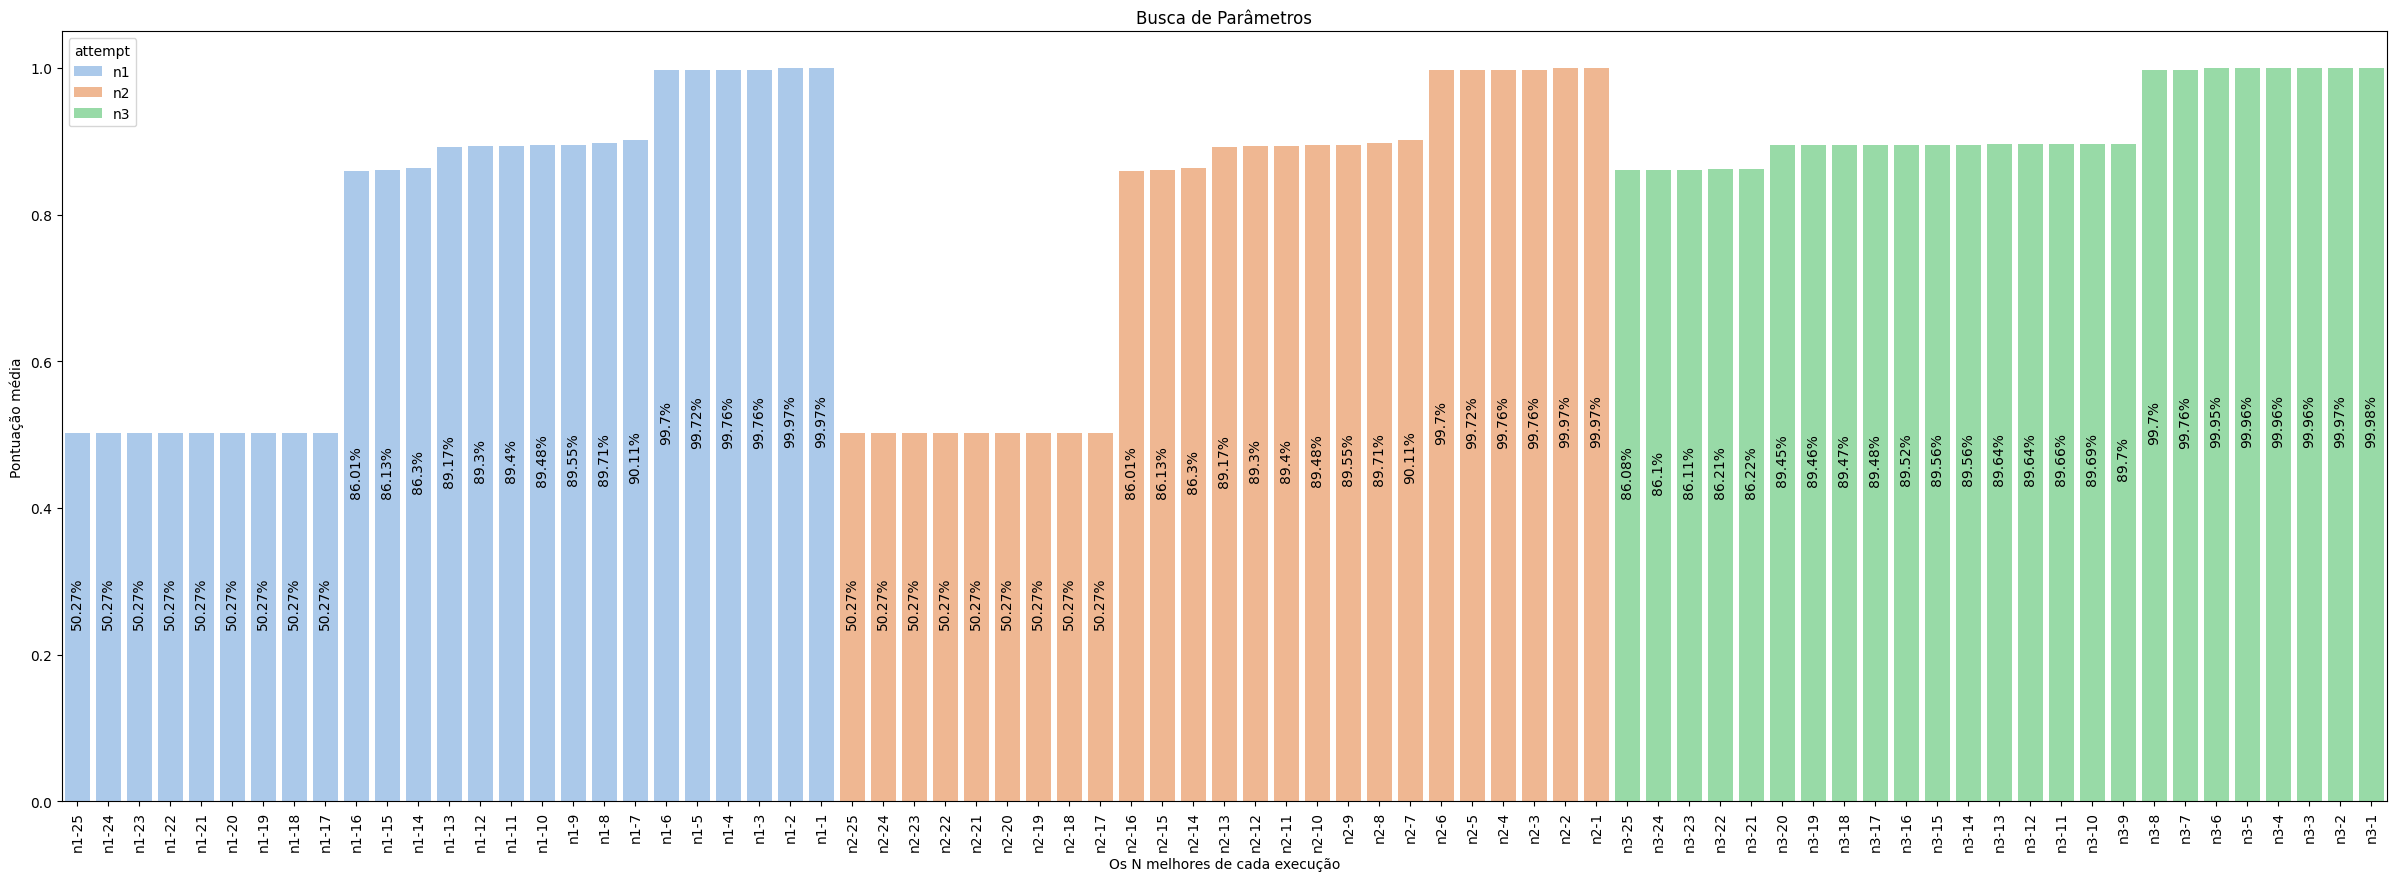

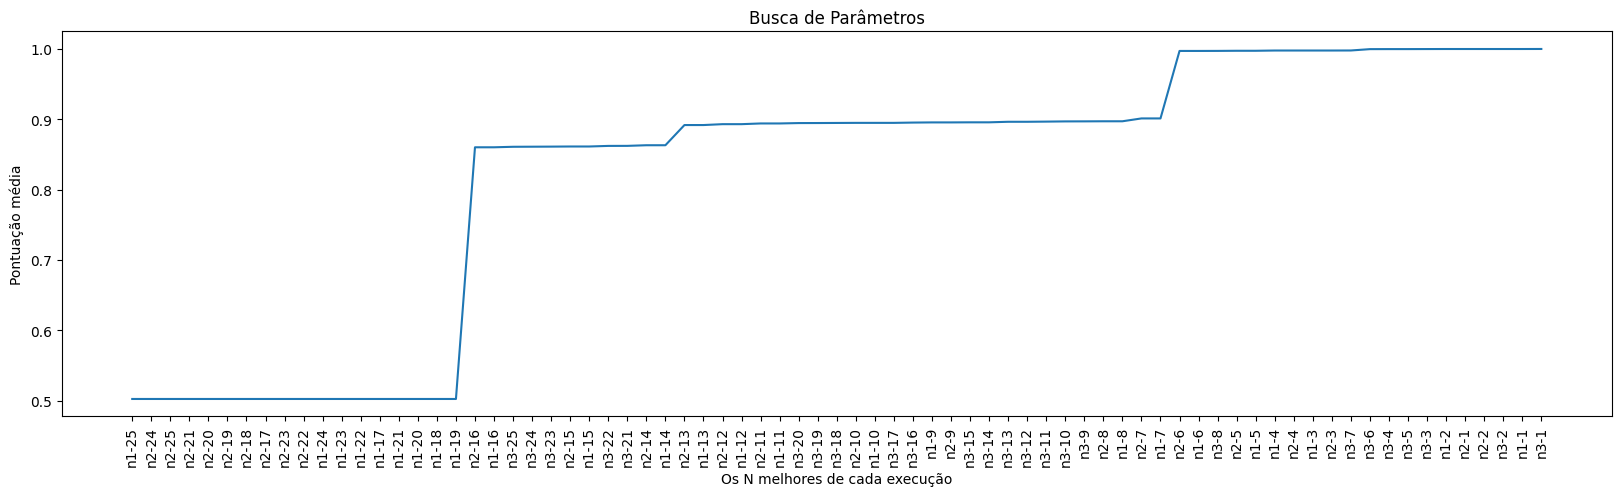

In [ ]:
show_params_search_graph("rfc")

### LVQ

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklvq import GLVQ

param_dist = {
    'glvq__distance_type': ['squared-euclidean', 'euclidean'],
    'glvq__activation_type': ['identity', 'sigmoid', 'soft+', 'swish'],
    'glvq__solver_type': ['sgd', 'bgd', 'adam', 'bfgs', 'lbfgs']
}

model = GLVQ()
scaler = MinMaxScaler()
lvq = make_pipeline(scaler, model)

In [ ]:
space_len = reduce(get_space_len, param_dist.values(), 1)

lvq_search, lvq_results = search_params("lvq", lvq, param_dist, space_len)

lvq_score = lvq_search.best_score_
lvq_params = lvq_search.best_params_

lvq_results, param_dist = remove_params_from_df(lvq_results, param_dist)

print(lvq_score, lvq_params)
lvq_results.head()

Searching 5/40 params of lvq
Saving params results in /content/drive/MyDrive/lvq.csv
Removing {'sgd'} params from glvq__solver_type
Removing {'sigmoid'} params from glvq__activation_type
0.8857755446021359 {'glvq__solver_type': 'lbfgs', 'glvq__distance_type': 'squared-euclidean', 'glvq__activation_type': 'identity'}


,param_glvq__solver_type,param_glvq__distance_type,param_glvq__activation_type,params,mean_test_score,std_test_score,rank_test_score
4,lbfgs,squared-euclidean,identity,"{'glvq__solver_type': 'lbfgs', 'glvq__distance...",0.885776,0.010641,1
3,bgd,euclidean,soft+,"{'glvq__solver_type': 'bgd', 'glvq__distance_t...",0.855970,0.018398,2


In [ ]:
lvq = make_pipeline(scaler, model)
space_len = reduce(get_space_len, param_dist.values(), 1)

lvq_search, lvq_results_2 = search_params("lvq_2", lvq, param_dist, space_len)

lvq_score = lvq_search.best_score_
lvq_params = lvq_search.best_params_

lvq_results = concatenate_results(lvq_results, lvq_results_2)
lvq_results, param_dist = remove_params_from_df(lvq_results, param_dist)

print(lvq_score, lvq_params)
lvq_results.head()

Searching 5/24 params of lvq_2
Saving params results in /content/drive/MyDrive/lvq_2.csv
Removing {'lbfgs'} params from glvq__solver_type
Removing {'euclidean'} params from glvq__distance_type
Removing {'identity'} params from glvq__activation_type
0.9046345004390812 {'glvq__solver_type': 'bgd', 'glvq__distance_type': 'squared-euclidean', 'glvq__activation_type': 'swish'}


,param_glvq__solver_type,param_glvq__distance_type,param_glvq__activation_type,params,mean_test_score,std_test_score,rank_test_score
2,bgd,squared-euclidean,swish,"{'glvq__solver_type': 'bgd', 'glvq__distance_t...",0.904635,0.009654,1
3,bfgs,squared-euclidean,swish,"{'glvq__solver_type': 'bfgs', 'glvq__distance_...",0.904575,0.009064,2
4,bgd,squared-euclidean,soft+,"{'glvq__solver_type': 'bgd', 'glvq__distance_t...",0.897971,0.010406,3


In [ ]:
lvq = make_pipeline(scaler, model)
space_len = reduce(get_space_len, param_dist.values(), 1)

lvq_search, lvq_results_2 = search_params("lvq_3", lvq, param_dist, space_len)

lvq_score = lvq_search.best_score_
lvq_params = lvq_search.best_params_

lvq_results = concatenate_results(lvq_results, lvq_results_2)
lvq_results, param_dist = remove_params_from_df(lvq_results, param_dist)

print(lvq_score, lvq_params)
lvq_results.head()

Searching 5/6 params of lvq_3
Saving params results in /content/drive/MyDrive/lvq_3.csv
Removing {'soft+'} params from glvq__activation_type
0.9045750828588426 {'glvq__solver_type': 'bfgs', 'glvq__distance_type': 'squared-euclidean', 'glvq__activation_type': 'swish'}


,param_glvq__solver_type,param_glvq__distance_type,param_glvq__activation_type,params,mean_test_score,std_test_score,rank_test_score
0,bgd,squared-euclidean,swish,"{'glvq__solver_type': 'bgd', 'glvq__distance_t...",0.904635,0.009654,1
1,bfgs,squared-euclidean,swish,"{'glvq__solver_type': 'bfgs', 'glvq__distance_...",0.904575,0.009064,2
3,bfgs,squared-euclidean,swish,"{'glvq__solver_type': 'bfgs', 'glvq__distance_...",0.904575,0.009064,1
4,adam,squared-euclidean,swish,"{'glvq__solver_type': 'adam', 'glvq__distance_...",0.902552,0.011712,2


In [ ]:
lvq_results = concatenate_results(lvq_results, lvq_results_2)

idx = lvq_results[0:1]["mean_test_score"].index[0]
lvq_score = lvq_results[0:1]["mean_test_score"][idx]
lvq_params = lvq_results[0:1]["params"][idx]
print(lvq_score, lvq_params)

0.9046345004390812 {'glvq__solver_type': 'bgd', 'glvq__distance_type': 'squared-euclidean', 'glvq__activation_type': 'swish'}


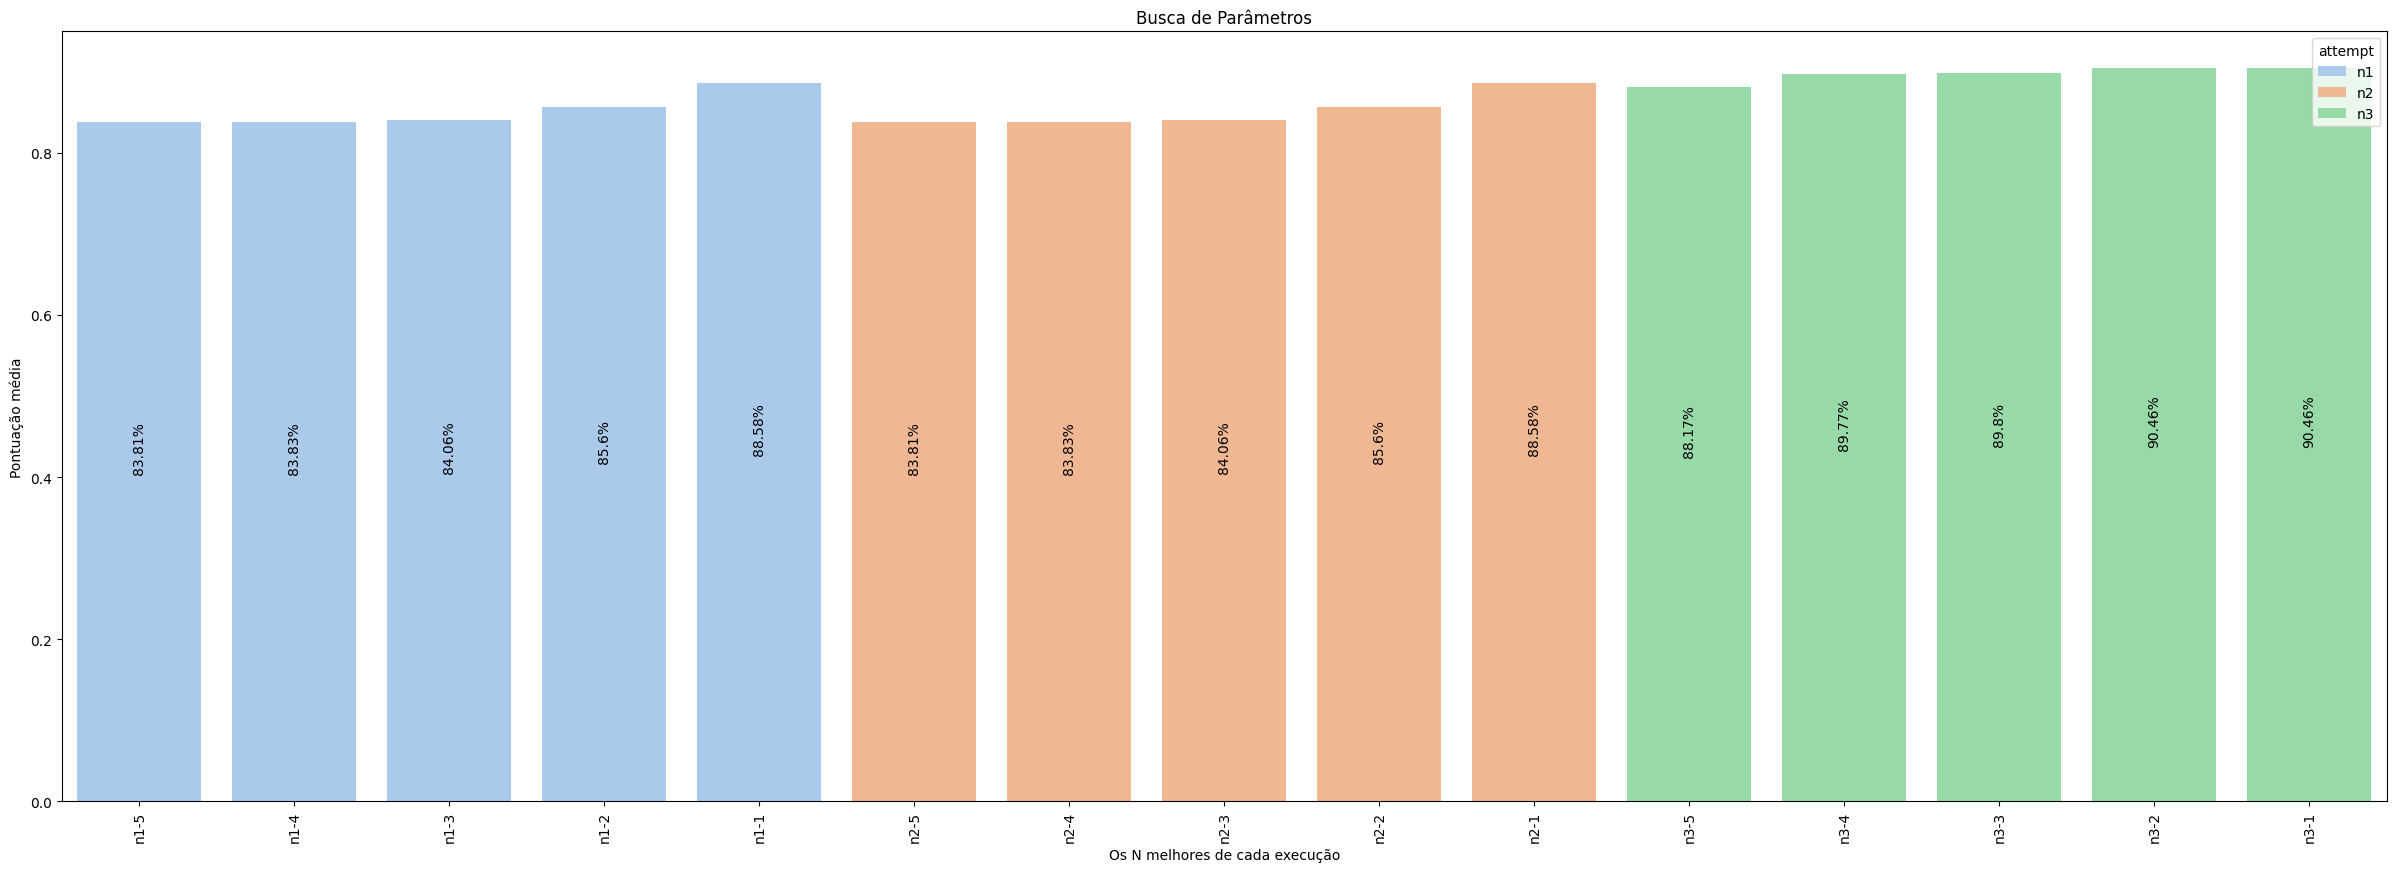

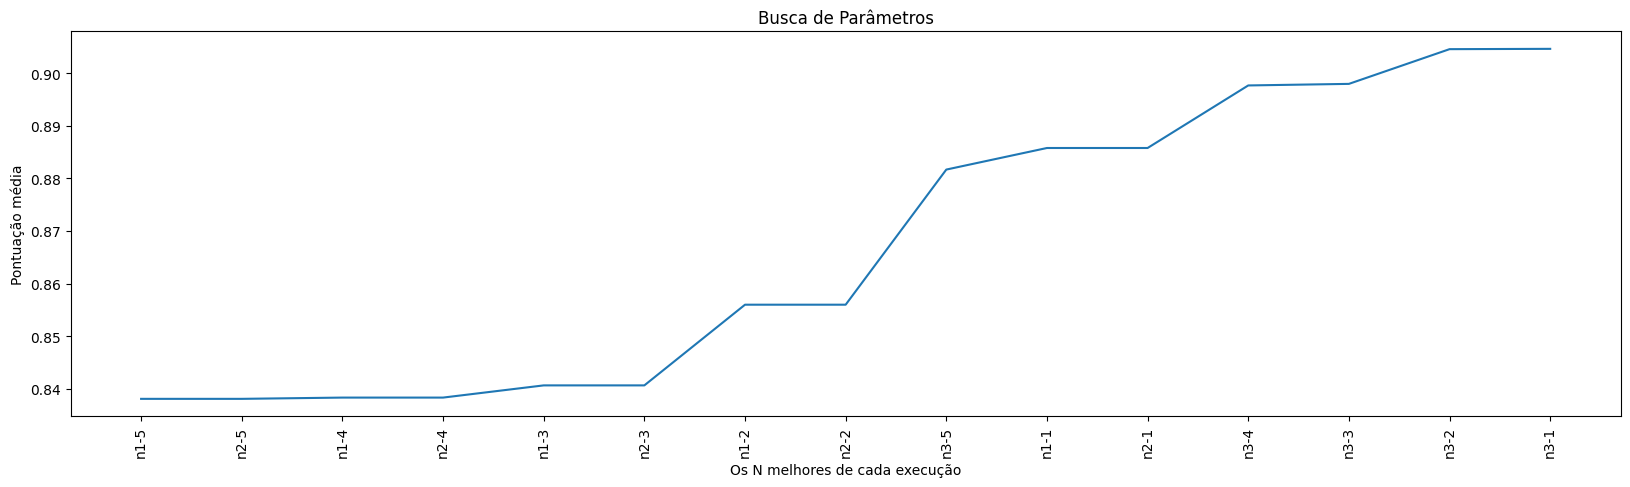

In [ ]:
show_params_search_graph("lvq")

### Comitê heterogêneo

Não é possível realizar uma busca de parâmetros nesse caso, mas uma vez que a busca de parâmetros foi feito em cada um dos modelos escolhidos, então serão usado os melhores parâmetros de cada modelo, para ver o resultado desses modelos juntos.

In [ ]:
from sklearn.ensemble import VotingClassifier

# 99.69% accuracy configuration
dtree = DecisionTreeClassifier(**{
    'class_weight': 'balanced',
    'max_depth': 10,
    'max_leaf_nodes': 30,
    'min_samples_leaf': 3,
    'min_samples_split': 6
})

# 99.99% accuracy configuration
svc = SVC(**{
    'tol': 0.0001,
    'max_iter': 100,
    'coef0': 0.2,
    'class_weight': 'balanced',
    'C': 100
})

# 99.99% accuracy configuration
knn = KNeighborsClassifier(**{
    'p': 3,
    'n_neighbors': 3,
    'metric': 'manhattan',
    'algorithm': 'brute',
    "n_jobs": -1
})

committee = VotingClassifier(estimators=[('dt', dtree), ('svc', svc), ('knn', knn)])

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(committee, teste_x, teste_y, cv=10, n_jobs=-1)
print("%0.2f de acurácia com desvio padrão de %0.2f" % (scores.mean() * 100, scores.std()))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-

99.99 de acurácia com desvio padrão de 0.00


### Comitê de redes neurais

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class NeuralNetworkCommittee(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator_params: list[dict]):
        self.estimator_params = estimator_params
        self.estimators_ = []

    def fit(self, X, y):
        for params in self.estimator_params:
            mlp = MLPClassifier(**params)
            mlp.fit(X, y)
            self.estimators_.append(mlp)
        return self

    def predict(self, X):
        get_max_pred = lambda x: 0 if len(x) == 1 else np.argmax(x)
        predictions = np.array([estimator.predict(X) for estimator in self.estimators_])
        return np.array(list(map(get_max_pred, map(np.bincount, predictions.T))))

In [ ]:
# 99.99% accuracy configuration
mlp1 = {
    'validation_fraction': 0.2,
    'tol': 0.001,
    'solver': 'lbfgs',
    'shuffle': False,
    'nesterovs_momentum': False,
    'momentum': 0.99,
    'learning_rate': 'adaptive',
    'hidden_layer_sizes': (150,),
    'early_stopping': True,
    'batch_size': 200,
    'alpha': 0.001,
    'activation': 'tanh'
}

# 99.99% accuracy configuration
mlp2 = {
    'warm_start': True,
    'validation_fraction': 0.15,
    'tol': 0.001,
    'solver': 'lbfgs',
    'momentum': 0.99,
    'max_iter': 400,
    'hidden_layer_sizes': (50, 50),
    'epsilon': 1e-07,
    'early_stopping': True,
    'beta_1': 0.99,
    'batch_size': 200,
    'activation': 'identity'
}

# 99.99% accuracy configuration
mlp3 = {
    'validation_fraction': 0.2,
    'tol': 0.001,
    'solver': 'lbfgs',
    'shuffle': False,
    'max_iter': 600,
    'learning_rate': 'adaptive',
    'hidden_layer_sizes': (200, 200),
    'epsilon': 1e-07,
    'beta_1': 0.99,
    'alpha': 0.1,
    'activation': 'logistic'
}

nnc = NeuralNetworkCommittee([mlp1, mlp2, mlp3])
nnc.fit(treino_x, treino_y)

NeuralNetworkCommittee(estimator_params=[{'activation': 'tanh', 'alpha': 0.001,
                                          'batch_size': 200,
                                          'early_stopping': True,
                                          'hidden_layer_sizes': (150,),
                                          'learning_rate': 'adaptive',
                                          'momentum': 0.99,
                                          'nesterovs_momentum': False,
                                          'shuffle': False, 'solver': 'lbfgs',
                                          'tol': 0.001,
                                          'validation_fraction': 0.2},
                                         {'activation': 'identity',
                                          'batch_size': 200, 'beta_1': 0.99,
                                          'early_st...
                                          'epsilon': 1e-07,
                                          'hidden_layer_sizes': (50, 50),
                                          'max_iter': 400, 'momentum': 0.99,
                                          'solver': 'lbfgs', 'tol': 0.001,
                                          'validation_fraction': 0.15,
                                          'warm_start': True},
                                         {'activation': 'logistic',
                                          'alpha': 0.1, 'beta_1': 0.99,
                                          'epsilon': 1e-07,
                                          'hidden_layer_sizes': (200, 200),
                                          'learning_rate': 'adaptive',
                                          'max_iter': 600, 'shuffle': False,
                                          'solver': 'lbfgs', 'tol': 0.001,
                                          'validation_fraction': 0.2}])

In [ ]:
scores = cross_val_score(nnc, teste_x, teste_y, cv=10, n_jobs=-1)
print("%0.2f de acurácia com desvio padrão de %0.2f" % (scores.mean() * 100, scores.std()))

100.00 de acurácia com desvio padrão de 0.00


## Evaluation

In [ ]:
mlp = MLPClassifier(**mlp1)
rfc = RandomForestClassifier(n_jobs=-1, **{
	'max_depth': 15,
	'max_features': None,
	'max_leaf_nodes': None,
	'min_impurity_decrease': 0.0,
	'min_samples_leaf': 2,
	'min_samples_split': 2,
	'n_estimators': 491,
	'oob_score': False,
	'warm_start': True
})

model = GLVQ(solver_type='bgd', activation_type='swish')
scaler = MinMaxScaler()
lvq = make_pipeline(scaler, model)

models = [('Árvore', dtree), ('SVM', svc), ('KNN', knn), ('RedeNeural', mlp),
 		  ('RandomForest', rfc), ("LVQ", lvq), ('ComiteHet', committee),
		   ('ComiteRede', nnc)]
scoring = 'accuracy'
results = []
names = []

from sklearn.model_selection import cross_val_score
print('Desempenho médio dos modelos:')
for name, model in models:
	cv_results = cross_val_score(model, treino_x, treino_y, cv=10, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	print(f"{name}: {cv_results.mean() * 100}% ({cv_results.std() * 100})")

Desempenho médio dos modelos:
Árvore: 99.67874847738024% (0.1335422999598624)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-

SVM: 99.99405116002379% (0.017846519928612636)
KNN: 99.99405116002379% (0.017846519928612636)
RedeNeural: 99.99405116002379% (0.017846519928612636)
RandomForest: 99.9702522591428% (0.04796327833785866)
LVQ: 90.51103722274159% (0.7511605252291725)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-

ComiteHet: 99.99405116002379% (0.017846519928612636)
ComiteRede: 99.99405116002379% (0.017846519928612636)


In [ ]:
from scipy import stats

stat, p = stats.kruskal(*results)
alpha = 0.05
if p > alpha:
	print('Mesma distribuição (fail to reject H0)')
else:
	print('Distribuições diferentes (reject H0)')

print('\nComparison stats', stat)

for i, current_result in enumerate(results):
    for j in range(i + 1, len(results)):
        current_name = models[i][0]
        next_name = models[j][0]
        print(f'Comparação {current_name} | {next_name}:',
              stats.kruskal(results[i],results[j]))

Distribuições diferentes (reject H0)

Comparison stats 63.43611250303086
Comparação Árvore | SVM: KruskalResult(statistic=15.754560530679925, pvalue=7.211388256866276e-05)
Comparação Árvore | KNN: KruskalResult(statistic=15.754560530679925, pvalue=7.211388256866276e-05)
Comparação Árvore | RedeNeural: KruskalResult(statistic=15.754560530679925, pvalue=7.211388256866276e-05)
Comparação Árvore | RandomForest: KruskalResult(statistic=14.413586097946286, pvalue=0.0001467398156898854)
Comparação Árvore | LVQ: KruskalResult(statistic=14.339622641509425, pvalue=0.00015261860208363206)
Comparação Árvore | ComiteHet: KruskalResult(statistic=15.754560530679925, pvalue=7.211388256866276e-05)
Comparação Árvore | ComiteRede: KruskalResult(statistic=15.754560530679925, pvalue=7.211388256866276e-05)
Comparação SVM | KNN: KruskalResult(statistic=0.0, pvalue=1.0)
Comparação SVM | RedeNeural: KruskalResult(statistic=0.0, pvalue=1.0)
Comparação SVM | RandomForest: KruskalResult(statistic=1.54869029275807

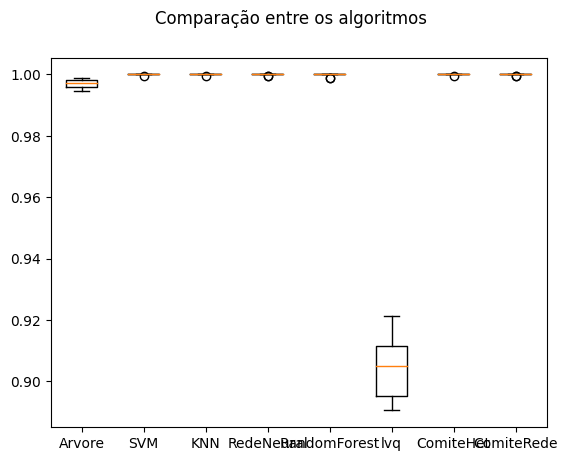

In [ ]:
fig = plt.figure()
fig.suptitle('Comparação entre os algoritmos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

stacked_results = np.hstack(results)

group_labels = np.concatenate([[i]*len(results[i]) for i in range(len(results))])

tukey_results = pairwise_tukeyhsd(stacked_results, group_labels)

print(tukey_results)


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.0032 0.2245 -0.0008  0.0071  False
     0      2   0.0032 0.2245 -0.0008  0.0071  False
     0      3   0.0032 0.2245 -0.0008  0.0071  False
     0      4   0.0029 0.3162 -0.0011  0.0069  False
     0      5  -0.0917    0.0 -0.0957 -0.0877   True
     0      6   0.0032 0.2245 -0.0008  0.0071  False
     0      7   0.0032 0.2245 -0.0008  0.0071  False
     1      2      0.0    1.0  -0.004   0.004  False
     1      3      0.0    1.0  -0.004   0.004  False
     1      4  -0.0002    1.0 -0.0042  0.0037  False
     1      5  -0.0948    0.0 -0.0988 -0.0908   True
     1      6      0.0    1.0  -0.004   0.004  False
     1      7      0.0    1.0  -0.004   0.004  False
     2      3      0.0    1.0  -0.004   0.004  False
     2      4  -0.0002    1.0 -0.0042  0.0037  False
     2      5  -0.0948    0.0 -0.0988 -0.0908 

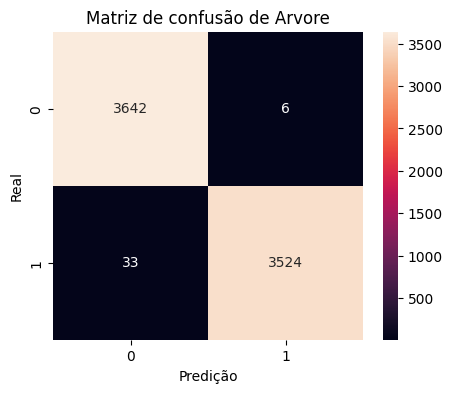

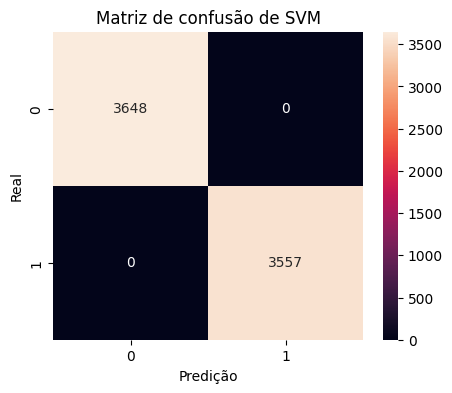

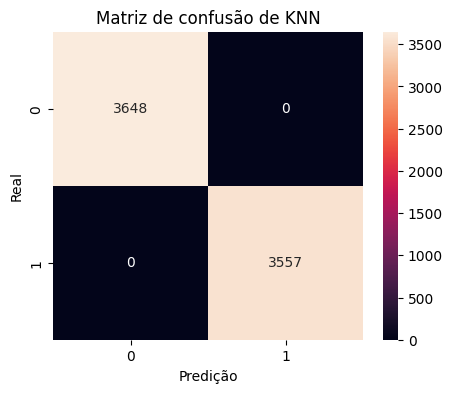

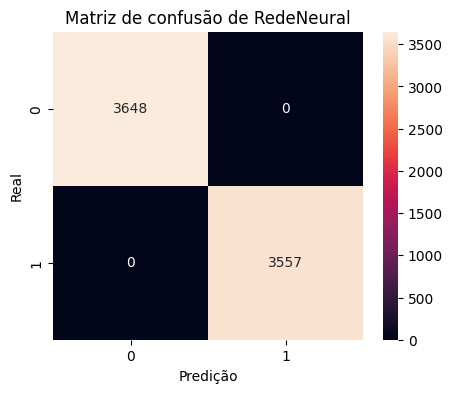

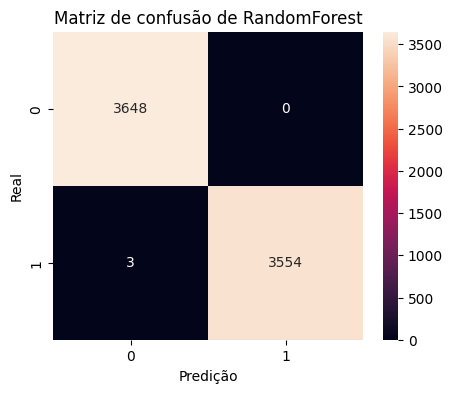

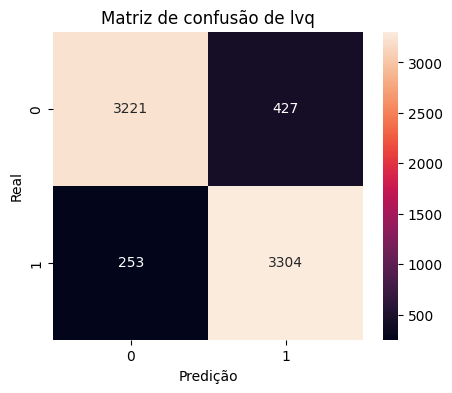

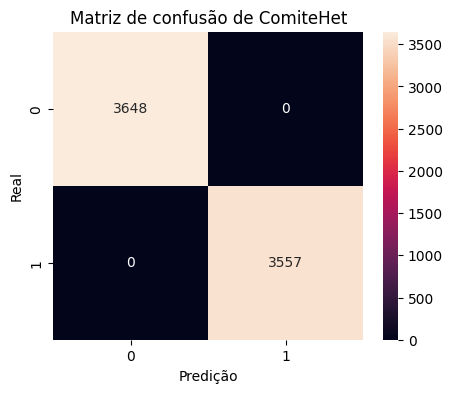

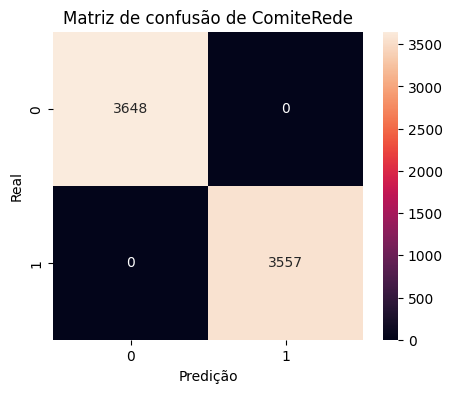

In [ ]:
import seaborn
from sklearn.metrics import confusion_matrix

for name, model in models:
    model.fit(treino_x, treino_y)
    c_matrix = confusion_matrix(teste_y, model.predict(teste_x))

    plt.figure(figsize = (5, 4))
    seaborn.heatmap(c_matrix, annot = True, fmt = "d").set(
        xlabel = "Predição", ylabel = "Real")
    plt.title(f"Matriz de confusão de {name}")